<a href="https://colab.research.google.com/github/Crippius/al_project/blob/main/al_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs, Imports and Initializations

In [ ]:
%%capture
!pip install sentence_transformers

In [ ]:
%%capture

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import euclidean_distances
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from IPython.display import display
from sklearn.manifold import TSNE
from keras import backend as K
from google.colab import drive
from math import pow, sqrt
import random
import time
import h5py


drive.mount('/content/drive')

In [ ]:
# @title Choose which dataset to use

# Default: "casualty"
LABEL = "casualty" #@param ["casualty", "damage", "weapons"]

# Default: 225000
SAMPLE = 225000 # @param {type:"slider", min:0, max:300000, step:1000}

df = pd.read_pickle(f"/content/drive/MyDrive/Uni/Terzo anno/Progetto di Ingegneria Informatica/al_project/datasets/{LABEL}.pickle")
if SAMPLE < len(df):
  df = df.sample(SAMPLE)

In [ ]:
%%capture
# @title Choose which embedding method to use
EMBEDDING_TYPE = "fast" # @param ["fast", "precise"]

types_of_embedding = {"fast":{"name":"all-MiniLM-L6-v2", "dim":384},
                   "precise":{"name":"all-mpnet-base-v2", "dim":768}}

EMBEDDING_MODEL = SentenceTransformer(types_of_embedding[EMBEDDING_TYPE]["name"])
EMBEDDING_DIMENSION = types_of_embedding[EMBEDDING_TYPE]["dim"]

In [ ]:
# @title Active Learning configurations

# Default: 1000
BUDGET = 1000 # @param {type:"slider", min:0, max:10000, step:100}

# Default: "minimax"
AL_METHOD = "minimax" # @param ["random", "farthest_first", "minimax"]

# Default: "normal"
# forgetful: lower threshold, consider just x amount of labels and just current timeframe
# normal: remember previous timeframes, just x amount of labels
# optimal: upper threshold, consider all labels, even from previous timeframes
AL_EFFICIENCY = "normal" # @param ["optimal", "normal", "forgetful"]

In [ ]:
# @title Neural network configurations

# Default: 15
EPOCHS = 15 # @param {type:"slider", min:0, max:100, step:1}
# Default: 32
BATCH_SIZE = 32 # @param {type:"slider", min:0, max:100, step:1}
# Default: 0.80
TRAIN_RATIO = 0.80 # @param {type:"slider", min:0, max:1, step:0.05}
# Default: 1e-3
LEARNING_RATE = 1e-3 # @param {type:"slider", min:0.00001, max:0.1, step:0.00001}
# Default: 0.20
VALIDATION_RATIO = 1-TRAIN_RATIO

In [ ]:
# @title Miscellanous parameters
# Default: 0.5
DECISION_THRESHOLD = 0.5 # @param {type:"slider", min:0, max:1, step:0.05}
# Default: 0.1
CLASSIFICATION_THRESHOLD = 0.1 # @param {type:"slider", min:0, max:1, step:0.1}
# Default: 24
TIMEFRAME = 24 # @param {type:"slider", min:1, max:100, step:1}

def decision(cnn_output):
  return cnn_output > DECISION_THRESHOLD

def classify(label):
  return label > CLASSIFICATION_THRESHOLD

# Seed initialization
SEED = 42 # @param {type:"integer"}

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# @title Additional possible operations
EXECUTE_EMBEDDING = False # @param {type:"boolean"}
CHECK_POSITION = True # @param {type:"boolean"}
TRAIN_ALL_DATA = True # @param {type:"boolean"}

In [ ]:
# @title Give it a name!
NAME = "prova" # @param {type:"string"}

## Dataset study


Example of Tweet

In [ ]:
print("Example of tweet")
x = df.sample()
x

Example of tweet


,tid,cid,text,retweet_count,like_count,text_clean,ts,casualty,embedding
110846,1498706122173149184,1.498706e+18,Why must we sit on the sidelines Ukraine needs...,0.0,0.0,Why must we sit on the sidelines Ukraine needs...,2022-03-01 16:05:58.796,0.2,"(-0.03671622276306152, -0.07561828941106796, 0..."


In [ ]:
print(x.iloc[0].text)

Why must we sit on the sidelines Ukraine needs support @POTUS @BillClinton @BarackObama I don’t understand why we just watch


In [ ]:
print(f"Example of tweet (possibly) talking about {LABEL}")
x = df[df[LABEL] == 1.0].sample()
x

Example of tweet (possibly) talking about casualty


,tid,cid,text,retweet_count,like_count,text_clean,ts,casualty,embedding
13408,1500545362083426309,1.500545e+18,@RonWyden Ukraine needs weapons and humanitari...,0.0,0.0,Ukraine needs weapons and humanitarian assista...,2022-03-06 17:54:27.762,1.0,"(-0.02270996756851673, 0.04172935336828232, -0..."


In [ ]:
print(x.iloc[0].text)

@RonWyden Ukraine needs weapons and humanitarian assistance to defend against #Putin. Stop innocent civilian deaths. @POTUS, provide #SafeAirliftUkraine #StopPutin


In [ ]:
df.dtypes

tid                      object
cid                     float64
text                     object
retweet_count           float64
like_count              float64
text_clean               object
ts               datetime64[ns]
casualty                float64
embedding                object
dtype: object

In [ ]:
df.describe()

,cid,retweet_count,like_count,ts,casualty
count,2.250000e+05,225000.000000,225000.000000,225000,225000.000000
mean,1.498532e+18,8.433458,41.032947,2022-03-01 04:54:29.284036352,0.178077
min,1.495978e+18,0.000000,0.000000,2022-02-22 04:23:39.921000,0.000000
25%,1.497187e+18,0.000000,0.000000,2022-02-25 12:30:29.419750144,0.000000
50%,1.498662e+18,0.000000,0.000000,2022-03-01 13:09:16.260499968,0.000000
75%,1.499778e+18,0.000000,2.000000,2022-03-04 15:06:07.285750016,0.200000
max,1.500985e+18,72907.000000,533225.000000,2022-03-07 22:59:58.775000,1.000000
std,1.469483e+15,234.160325,1456.024876,NaN,0.333582


Percent of tweets possibly talking about casualty: 28.56%


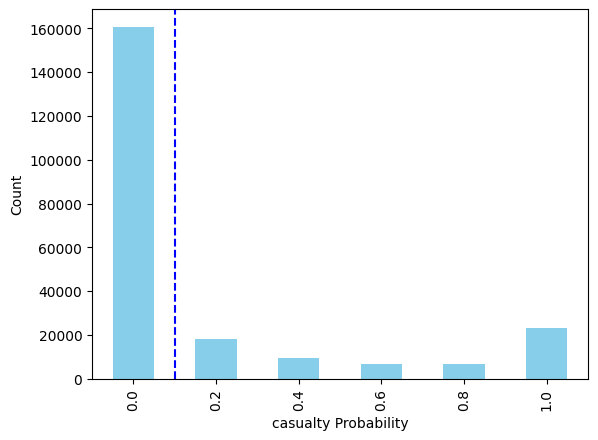

In [ ]:
print(f"Percent of tweets possibly talking about {LABEL}: {round(100 * len(df[df[LABEL] > CLASSIFICATION_THRESHOLD]) / len(df), 2)}%")


counts = df[LABEL].round(2).value_counts().sort_index()
counts.plot(kind='bar', color='skyblue')
plt.axvline(x=CLASSIFICATION_THRESHOLD*5, color='blue', linestyle='--')
plt.xlabel(f'{LABEL} Probability')
plt.ylabel('Count')
plt.show()

In [ ]:
min_date = df.ts.min().date()
max_date = df.ts.max().date()
print(f"Batch of tweets about Ukraine's conflict uploaded from {min_date} to {max_date}")

Batch of tweets about Ukraine's conflict uploaded from 2022-02-22 to 2022-03-07


Average number of tweets per day: 16071.0 tweets


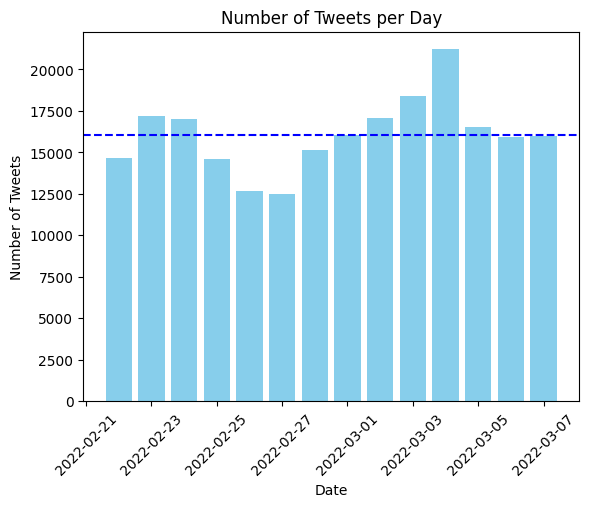

In [ ]:
tweets_per_day = df["ts"].dt.date.value_counts().sort_index()
# Plotting the histogram
mean = round(sum(tweets_per_day.values) / len(tweets_per_day.values), 0)
print(f"Average number of tweets per day: {mean} tweets")

plt.bar(tweets_per_day.index, tweets_per_day.values, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Day')
plt.axhline(y=mean, color='blue', linestyle='--')
plt.xticks(rotation=45)
plt.show()

## Embedding tweets

In [ ]:
# Returns the same df but with an additional column "embedding" of the (clean) tweet
def embed_df(df):

    embedded_tweets = EMBEDDING_MODEL.encode(df["text_clean"])

    df["embedding"] = embedded_tweets

    return df


# Returns embedded text
def embed_text(txt):

    return EMBEDDING_MODEL.encode(txt)

In [ ]:
if EXECUTE_EMBEDDING:
  df = embed_df(df)

## Building the model

In [ ]:
# Metrics to check during model training

# Recall: ability to identify all relevant instances (TP / TP + FN)
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Precision: ability to distinguish relevant instances from others (TP / TP + FP)
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1: mean of precision and recall (2*precision*recall / precision+recall)
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def create_model():

  model = tf.keras.Sequential([
      tf.keras.Input(shape=(EMBEDDING_DIMENSION,), dtype="float32"),
      tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
  ])
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics = [tf.keras.metrics.BinaryAccuracy(threshold=DECISION_THRESHOLD), recall_m, precision_m, f1_m])

  # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10).
  # Get only the best model out of every epoch
  callback = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy', save_best_only=True, mode='max', verbose=0, patience=10, filepath='prova.h5')

  return model, callback


model, _ = create_model()

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                24640     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 batch_normalization_1 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

In [ ]:
def save_model(model, title="prova",  metrics={}, path="/content/drive/MyDrive/Uni/Terzo anno/Progetto di Ingegneria Informatica/al_project/models/"):
  model.save(path+title+".h5")

  with h5py.File(path+title+".h5", 'a') as f:

    file_parameters = f.create_group('parameters')

    params = {"DATASET":LABEL,
              "EMBEDDING":EMBEDDING_TYPE,
              "AL_METHOD":AL_METHOD,
              "AL_EFFICIENCY":AL_EFFICIENCY,
              "BUDGET":BUDGET,
              "TIMEFRAME":TIMEFRAME,
              "LEARNING_RATE":LEARNING_RATE,
              "DECISION_THRESHOLD":DECISION_THRESHOLD,
              "CLASSIFICATION_THRESHOLD":CLASSIFICATION_THRESHOLD,}

    # Store additional parameters
    for i, j in params.items():
      file_parameters.create_dataset(i, data=j)

    if metrics != {}:
      file_metrics = f.create_group('metrics')
      for i, j in metrics.items():
        file_metrics.create_dataset(i, data=j)




## Active Learning Methods

In [ ]:
def cs_farthest_first_selection(df, labelled, budget, label_column):
  df = df.reset_index(drop=True)

  points = df["embedding"].tolist()

  distances = euclidean_distances(points, points)


  while budget > 0:

    chosen = random.randint(0, len(df) - 1)

    furthest = 0
    furthest_dist = 0

    # Searching for the element furthest away from the currently chosen one
    for i in range(len(df)):


      total_distance = distances[chosen, i]

      if furthest_dist < total_distance:
        # Avoiding elements already labelled
        if df.iloc[i]["embedding"] in list(labelled.keys()):
          continue
        furthest = i
        furthest_dist = total_distance


    labelled[df.iloc[furthest]["embedding"]] = classify(df.iloc[furthest][LABEL])

    budget -= 1


  return labelled


In [ ]:
# Core Set: Minimax (Robust version)
def cs_minimax_selection(df, labelled, budget, label_column):
  df = df.reset_index(drop=True)

  start_budget = budget

  points = df["embedding"].tolist()

  if len(labelled) == 0:
      labelled = {df.iloc[0]["embedding"]:df.iloc[0][LABEL]}

  distances = euclidean_distances(np.array(list(labelled.keys())), points)

  min_values = distances.min(axis=0)

  distances = euclidean_distances(points, points)


  while budget > 0:
    # Get argmax of minimum distances
    argmax = min_values.argmax()

    labelled[df.iloc[argmax]["embedding"]] = classify(df.iloc[argmax][LABEL])

    min_values = np.array([min(min_values[i], distances[argmax][i]) for i in range(len(min_values))])

    budget -= 1

  return labelled

In [ ]:
# Good old random selection
def random_selection(curr, labelled:dict, budget:int, label_column:str):

  curr = curr.sample(budget)
  for i, label in zip(curr['embedding'], curr[label_column]):
    labelled[i] = classify(label)

  return labelled


In [ ]:
al_methods = {"minimax":cs_minimax_selection,
              "farthest_first":cs_farthest_first_selection,
              "random":random_selection}

In [ ]:
# Testing if Core Set Farthest First selection works
def check_label_position(df, labels, show_label=False):

  test = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=4).fit_transform(np.array(list(df["embedding"])))
  test = pd.DataFrame(test, columns = ["0_", "1_"])

  test["selected"] = [1 if i in labels.keys() else 0 for i in df["embedding"]]
  test[LABEL] = [i for i in df[LABEL]]
  test_labelled = test[test["selected"] == 1]

  plt.scatter(test["0_"], test["1_"], marker="x", c="black")
  if show_label:
    false_labels = test_labelled[test_labelled[LABEL] == 0]
    plt.scatter(false_labels["0_"], false_labels["1_"], marker="x", c="red")
    true_labels = test_labelled[test_labelled[LABEL] == 1]
    plt.scatter(true_labels["0_"], true_labels["1_"], marker="x", c="green")

  else:
    plt.scatter(test_labelled["0_"], test_labelled["1_"], marker="x", c="cyan")

  plt.show()


minimax selection


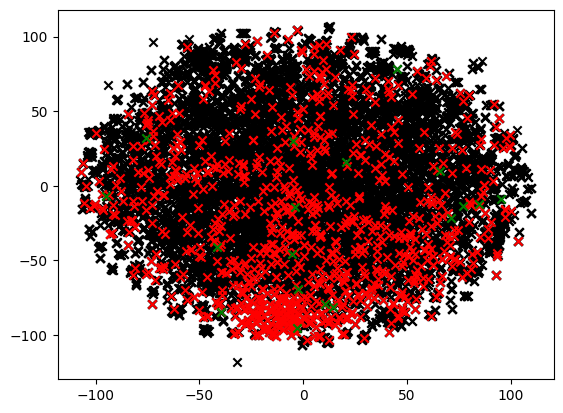

farthest_first selection


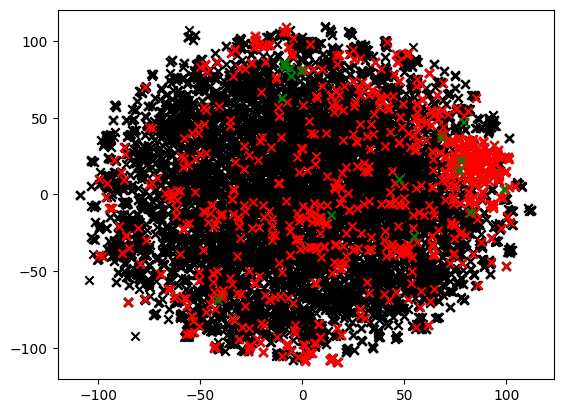

random selection


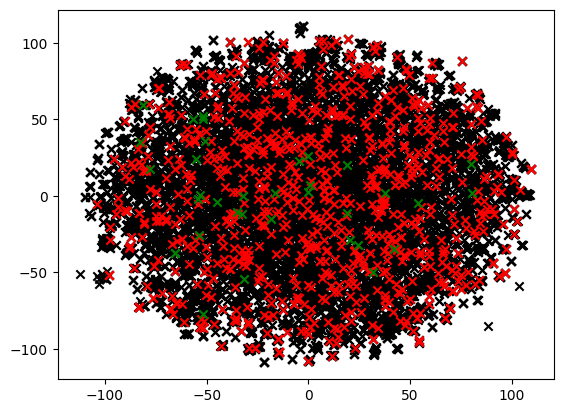

In [ ]:
if CHECK_POSITION:
  curr = df[df.ts.dt.date == min_date]

  for method in al_methods.keys():
    labelled_elements = al_methods[method](curr, {}, BUDGET, LABEL)
    print(f"{method} selection")
    check_label_position(curr, labelled_elements, show_label=True)


In [ ]:
def get_network_sets(x, y, next):

  # Splitting data into training, validation and test set
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=TRAIN_RATIO, random_state=SEED)
  x_test, y_test = next['embedding'], [classify(i) for i in next[LABEL]]

  # Changing format to correctly use in neural network
  x_train = np.array([np.array(val) for val in x_train])
  y_train = np.array([np.array(val) for val in y_train])
  x_test = np.array([np.array(val) for val in x_test])
  y_test = np.array([np.array(val) for val in y_test])
  x_val = np.array([np.array(val) for val in x_val])
  y_val = np.array([np.array(val) for val in y_val])

  x_train = tf.cast(x_train , dtype=tf.float32)
  y_train = tf.cast(y_train , dtype=tf.float32)
  x_test = tf.cast(x_test , dtype=tf.float32)
  y_test = tf.cast(y_test , dtype=tf.float32)
  x_val = tf.cast(x_train , dtype=tf.float32)
  y_val = tf.cast(y_train , dtype=tf.float32)


  return x_train, y_train, x_test, y_test, x_val, y_val

In [ ]:
def plot_results(history, train=True, validation=True, precision=False, recall=False, f1=False):

  legend = []
  if train:
    plt.plot(history.history['binary_accuracy'])
    legend.append("train")
  if validation:
    plt.plot(history.history['val_binary_accuracy'])
    legend.append("validation")
  if precision:
    plt.plot(history.history['precision_m'])
    legend.append("precision")
  if recall:
    plt.plot(history.history['recall_m'])
    legend.append("recall")
  if f1:
    plt.plot(history.history['f1_m'])
    legend.append("f1")

  plt.title(f'model accuracy')
  plt.ylabel('performance metrics')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.show()

Epoch 1/15
1407/1407 [==============================] - ETA: 0s - loss: 0.2551 - binary_accuracy: 0.6354 - recall_m: 0.7378 - precision_m: 0.3306 - f1_m: 0.4376

1407/1407 [==============================] - 19s 8ms/step - loss: 0.2551 - binary_accuracy: 0.6354 - recall_m: 0.7378 - precision_m: 0.3306 - f1_m: 0.4376 - val_loss: 0.4342 - val_binary_accuracy: 0.6866 - val_recall_m: 0.7509 - val_precision_m: 0.3714 - val_f1_m: 0.4832
Epoch 2/15
1402/1407 [============================>.] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.6916 - recall_m: 0.7504 - precision_m: 0.3911 - f1_m: 0.4952

1407/1407 [==============================] - 12s 8ms/step - loss: 0.2324 - binary_accuracy: 0.6917 - recall_m: 0.7504 - precision_m: 0.3917 - f1_m: 0.4958 - val_loss: 0.3723 - val_binary_accuracy: 0.7178 - val_recall_m: 0.7373 - val_precision_m: 0.4204 - val_f1_m: 0.5200
Epoch 3/15
1400/1407 [============================>.] - ETA: 0s - loss: 0.2271 - binary_accuracy: 0.6958 - recall_m: 0.7507 - precision_m: 0.3967 - f1_m: 0.4997

1407/1407 [==============================] - 14s 10ms/step - loss: 0.2272 - binary_accuracy: 0.6960 - recall_m: 0.7501 - precision_m: 0.3968 - f1_m: 0.4997 - val_loss: 0.3452 - val_binary_accuracy: 0.7370 - val_recall_m: 0.7178 - val_precision_m: 0.4584 - val_f1_m: 0.5436
Epoch 4/15
1399/1407 [============================>.] - ETA: 0s - loss: 0.2225 - binary_accuracy: 0.7027 - recall_m: 0.7510 - precision_m: 0.4082 - f1_m: 0.5108

1407/1407 [==============================] - 14s 10ms/step - loss: 0.2225 - binary_accuracy: 0.7026 - recall_m: 0.7498 - precision_m: 0.4072 - f1_m: 0.5095 - val_loss: 0.3918 - val_binary_accuracy: 0.7056 - val_recall_m: 0.7675 - val_precision_m: 0.4058 - val_f1_m: 0.5165
Epoch 5/15
1401/1407 [============================>.] - ETA: 0s - loss: 0.2208 - binary_accuracy: 0.7047 - recall_m: 0.7649 - precision_m: 0.4133 - f1_m: 0.5156

1407/1407 [==============================] - 14s 10ms/step - loss: 0.2209 - binary_accuracy: 0.7046 - recall_m: 0.7644 - precision_m: 0.4131 - f1_m: 0.5153 - val_loss: 0.3578 - val_binary_accuracy: 0.7298 - val_recall_m: 0.7459 - val_precision_m: 0.4434 - val_f1_m: 0.5412
Epoch 6/15
1401/1407 [============================>.] - ETA: 0s - loss: 0.2187 - binary_accuracy: 0.7055 - recall_m: 0.7597 - precision_m: 0.4122 - f1_m: 0.5134

1407/1407 [==============================] - 12s 8ms/step - loss: 0.2189 - binary_accuracy: 0.7057 - recall_m: 0.7598 - precision_m: 0.4125 - f1_m: 0.5135 - val_loss: 0.3717 - val_binary_accuracy: 0.7143 - val_recall_m: 0.7700 - val_precision_m: 0.4124 - val_f1_m: 0.5229
Epoch 7/15
1402/1407 [============================>.] - ETA: 0s - loss: 0.2175 - binary_accuracy: 0.7060 - recall_m: 0.7618 - precision_m: 0.4141 - f1_m: 0.5160

1407/1407 [==============================] - 14s 10ms/step - loss: 0.2174 - binary_accuracy: 0.7060 - recall_m: 0.7622 - precision_m: 0.4142 - f1_m: 0.5162 - val_loss: 0.3904 - val_binary_accuracy: 0.7057 - val_recall_m: 0.7786 - val_precision_m: 0.4016 - val_f1_m: 0.5161
Epoch 8/15
1405/1407 [============================>.] - ETA: 0s - loss: 0.2139 - binary_accuracy: 0.7102 - recall_m: 0.7589 - precision_m: 0.4165 - f1_m: 0.5182

1407/1407 [==============================] - 14s 10ms/step - loss: 0.2139 - binary_accuracy: 0.7103 - recall_m: 0.7586 - precision_m: 0.4163 - f1_m: 0.5180 - val_loss: 0.3807 - val_binary_accuracy: 0.7083 - val_recall_m: 0.7718 - val_precision_m: 0.3984 - val_f1_m: 0.5126
Epoch 9/15
1404/1407 [============================>.] - ETA: 0s - loss: 0.2125 - binary_accuracy: 0.7101 - recall_m: 0.7621 - precision_m: 0.4195 - f1_m: 0.5193

1407/1407 [==============================] - 14s 10ms/step - loss: 0.2125 - binary_accuracy: 0.7100 - recall_m: 0.7621 - precision_m: 0.4194 - f1_m: 0.5192 - val_loss: 0.3536 - val_binary_accuracy: 0.7266 - val_recall_m: 0.7656 - val_precision_m: 0.4343 - val_f1_m: 0.5403
Epoch 10/15
1405/1407 [============================>.] - ETA: 0s - loss: 0.2087 - binary_accuracy: 0.7140 - recall_m: 0.7612 - precision_m: 0.4247 - f1_m: 0.5259

1407/1407 [==============================] - 13s 9ms/step - loss: 0.2087 - binary_accuracy: 0.7140 - recall_m: 0.7608 - precision_m: 0.4245 - f1_m: 0.5256 - val_loss: 0.3871 - val_binary_accuracy: 0.7041 - val_recall_m: 0.8017 - val_precision_m: 0.4066 - val_f1_m: 0.5256
Epoch 11/15
1403/1407 [============================>.] - ETA: 0s - loss: 0.2082 - binary_accuracy: 0.7155 - recall_m: 0.7565 - precision_m: 0.4279 - f1_m: 0.5279

1407/1407 [==============================] - 12s 8ms/step - loss: 0.2082 - binary_accuracy: 0.7155 - recall_m: 0.7558 - precision_m: 0.4274 - f1_m: 0.5273 - val_loss: 0.3567 - val_binary_accuracy: 0.7215 - val_recall_m: 0.7801 - val_precision_m: 0.4240 - val_f1_m: 0.5359
Epoch 12/15
1403/1407 [============================>.] - ETA: 0s - loss: 0.2074 - binary_accuracy: 0.7145 - recall_m: 0.7652 - precision_m: 0.4240 - f1_m: 0.5253

1407/1407 [==============================] - 11s 8ms/step - loss: 0.2074 - binary_accuracy: 0.7145 - recall_m: 0.7650 - precision_m: 0.4240 - f1_m: 0.5253 - val_loss: 0.3753 - val_binary_accuracy: 0.7090 - val_recall_m: 0.7903 - val_precision_m: 0.4049 - val_f1_m: 0.5222
Epoch 13/15
1401/1407 [============================>.] - ETA: 0s - loss: 0.2058 - binary_accuracy: 0.7151 - recall_m: 0.7654 - precision_m: 0.4264 - f1_m: 0.5277

1407/1407 [==============================] - 14s 10ms/step - loss: 0.2057 - binary_accuracy: 0.7154 - recall_m: 0.7656 - precision_m: 0.4264 - f1_m: 0.5279 - val_loss: 0.3133 - val_binary_accuracy: 0.7494 - val_recall_m: 0.7481 - val_precision_m: 0.4777 - val_f1_m: 0.5693
Epoch 14/15
1401/1407 [============================>.] - ETA: 0s - loss: 0.2054 - binary_accuracy: 0.7164 - recall_m: 0.7669 - precision_m: 0.4288 - f1_m: 0.5300

1407/1407 [==============================] - 11s 8ms/step - loss: 0.2052 - binary_accuracy: 0.7162 - recall_m: 0.7669 - precision_m: 0.4283 - f1_m: 0.5296 - val_loss: 0.3472 - val_binary_accuracy: 0.7232 - val_recall_m: 0.7790 - val_precision_m: 0.4217 - val_f1_m: 0.5337
Epoch 15/15
1400/1407 [============================>.] - ETA: 0s - loss: 0.2033 - binary_accuracy: 0.7173 - recall_m: 0.7701 - precision_m: 0.4296 - f1_m: 0.5316

7032/7032 [==============================] - 21s 3ms/step - loss: 0.3974 - binary_accuracy: 0.8223 - recall_m: 0.6852 - precision_m: 0.6915 - f1_m: 0.6753
Train Accuracy
1407/1407 [==============================] - 4s 3ms/step - loss: 0.3317 - binary_accuracy: 0.7332 - recall_m: 0.7767 - precision_m: 0.4475 - f1_m: 0.5537
Test Accuracy
7032/7032 [==============================] - 22s 3ms/step - loss: 0.3974 - binary_accuracy: 0.8223 - recall_m: 0.6852 - precision_m: 0.6915 - f1_m: 0.6753


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


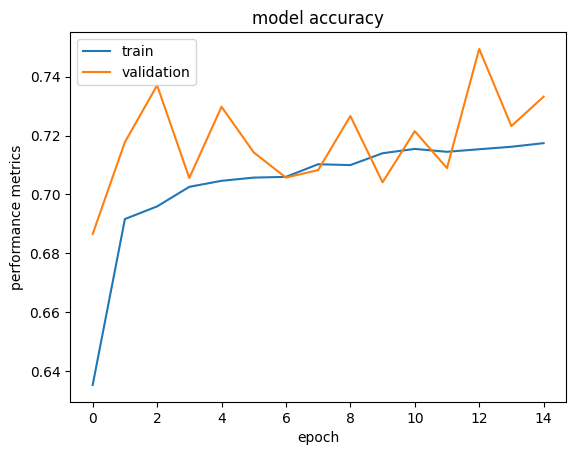

In [ ]:
if TRAIN_ALL_DATA:

  curr = df[df.ts.dt.date != max_date]
  next = df[df.ts.dt.date == max_date]

  x, y = df["embedding"], df[LABEL]

  # Getting correct sets
  x_train, y_train, x_test, y_test, x_val, y_val = get_network_sets(x, y, df)

  # Creating model
  model, callback = create_model()

  # Calculating weights for better cnn performance
  class_weights = compute_class_weight(class_weight='balanced', classes=list(set(y)), y=y)
  class_weights = {class_index: weight for class_index, weight in enumerate(class_weights)}

  # Training model
  history = model.fit(x_train, y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=1,
                      validation_data=([x_val, y_val]),
                      callbacks=callback,
                      class_weight=class_weights)

  # Evaluating Model
  model.evaluate(x_test, y_test, verbose=1)

  print('Train Accuracy')
  model.evaluate(x_train, y_train)
  print('Test Accuracy')
  model.evaluate(x_test, y_test)

  save_model(model, title="best_result")

  plot_results(history)

Epoch 1/15
1/7 [===>..........................] - ETA: 11s - loss: 0.9514 - binary_accuracy: 0.4375 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 2s 62ms/step - loss: 0.7249 - binary_accuracy: 0.4550 - recall_m: 0.1786 - precision_m: 0.0317 - f1_m: 0.0532 - val_loss: 0.6875 - val_binary_accuracy: 0.6800 - val_recall_m: 0.3095 - val_precision_m: 0.0556 - val_f1_m: 0.0900
Epoch 2/15
1/7 [===>..........................] - ETA: 0s - loss: 0.5025 - binary_accuracy: 0.5000 - recall_m: 1.0000 - precision_m: 0.0588 - f1_m: 0.1111

7/7 [==============================] - 0s 13ms/step - loss: 0.5451 - binary_accuracy: 0.5400 - recall_m: 0.7143 - precision_m: 0.0814 - f1_m: 0.1435 - val_loss: 0.6817 - val_binary_accuracy: 0.8700 - val_recall_m: 0.3095 - val_precision_m: 0.1286 - val_f1_m: 0.1786
Epoch 3/15
1/7 [===>..........................] - ETA: 0s - loss: 0.4366 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.0667 - f1_m: 0.1250

7/7 [==============================] - 0s 13ms/step - loss: 0.5468 - binary_accuracy: 0.5350 - recall_m: 0.3929 - precision_m: 0.0656 - f1_m: 0.1071 - val_loss: 0.6750 - val_binary_accuracy: 0.9550 - val_recall_m: 0.3095 - val_precision_m: 0.2857 - val_f1_m: 0.2810
Epoch 4/15
1/7 [===>..........................] - ETA: 0s - loss: 1.0179 - binary_accuracy: 0.5000 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 12ms/step - loss: 0.6249 - binary_accuracy: 0.5250 - recall_m: 0.6429 - precision_m: 0.0825 - f1_m: 0.1414 - val_loss: 0.6671 - val_binary_accuracy: 0.9600 - val_recall_m: 0.3095 - val_precision_m: 0.2857 - val_f1_m: 0.2810
Epoch 5/15
1/7 [===>..........................] - ETA: 0s - loss: 0.4472 - binary_accuracy: 0.4375 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 13ms/step - loss: 0.4662 - binary_accuracy: 0.5400 - recall_m: 0.7143 - precision_m: 0.1170 - f1_m: 0.1932 - val_loss: 0.6596 - val_binary_accuracy: 0.9750 - val_recall_m: 0.3571 - val_precision_m: 0.3571 - val_f1_m: 0.3571
Epoch 6/15
1/7 [===>..........................] - ETA: 0s - loss: 0.5673 - binary_accuracy: 0.6875 - recall_m: 0.5000 - precision_m: 0.1000 - f1_m: 0.1667

7/7 [==============================] - 0s 13ms/step - loss: 0.5130 - binary_accuracy: 0.5300 - recall_m: 0.5714 - precision_m: 0.0684 - f1_m: 0.1205 - val_loss: 0.6549 - val_binary_accuracy: 0.9800 - val_recall_m: 0.4286 - val_precision_m: 0.5000 - val_f1_m: 0.4524
Epoch 7/15
1/7 [===>..........................] - ETA: 0s - loss: 0.6758 - binary_accuracy: 0.5625 - recall_m: 0.6667 - precision_m: 0.1333 - f1_m: 0.2222

7/7 [==============================] - 0s 14ms/step - loss: 0.4749 - binary_accuracy: 0.5450 - recall_m: 0.5238 - precision_m: 0.0811 - f1_m: 0.1368 - val_loss: 0.6504 - val_binary_accuracy: 0.9800 - val_recall_m: 0.4286 - val_precision_m: 0.5000 - val_f1_m: 0.4524
Epoch 8/15
1/7 [===>..........................] - ETA: 0s - loss: 0.3573 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.1818 - f1_m: 0.3077

7/7 [==============================] - 0s 13ms/step - loss: 0.4308 - binary_accuracy: 0.6400 - recall_m: 0.8571 - precision_m: 0.1307 - f1_m: 0.2229 - val_loss: 0.6426 - val_binary_accuracy: 0.9800 - val_recall_m: 0.4286 - val_precision_m: 0.5000 - val_f1_m: 0.4524
Epoch 9/15
1/7 [===>..........................] - ETA: 0s - loss: 0.4398 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.0714 - f1_m: 0.1333

7/7 [==============================] - 0s 13ms/step - loss: 0.4381 - binary_accuracy: 0.5900 - recall_m: 0.7143 - precision_m: 0.0966 - f1_m: 0.1651 - val_loss: 0.6350 - val_binary_accuracy: 0.9800 - val_recall_m: 0.4286 - val_precision_m: 0.5000 - val_f1_m: 0.4524
Epoch 10/15
1/7 [===>..........................] - ETA: 0s - loss: 0.4880 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1333 - f1_m: 0.2353

7/7 [==============================] - 0s 13ms/step - loss: 0.4053 - binary_accuracy: 0.5900 - recall_m: 0.7143 - precision_m: 0.0869 - f1_m: 0.1539 - val_loss: 0.6268 - val_binary_accuracy: 0.9800 - val_recall_m: 0.4286 - val_precision_m: 0.5000 - val_f1_m: 0.4524
Epoch 11/15
1/7 [===>..........................] - ETA: 0s - loss: 0.3236 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.0833 - f1_m: 0.1538

7/7 [==============================] - 0s 12ms/step - loss: 0.4151 - binary_accuracy: 0.6400 - recall_m: 0.7143 - precision_m: 0.1025 - f1_m: 0.1762 - val_loss: 0.6199 - val_binary_accuracy: 0.9800 - val_recall_m: 0.4286 - val_precision_m: 0.5000 - val_f1_m: 0.4524
Epoch 12/15
1/7 [===>..........................] - ETA: 0s - loss: 0.3505 - binary_accuracy: 0.5312 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 12ms/step - loss: 0.3706 - binary_accuracy: 0.6350 - recall_m: 0.5714 - precision_m: 0.0915 - f1_m: 0.1519 - val_loss: 0.6136 - val_binary_accuracy: 0.9800 - val_recall_m: 0.4286 - val_precision_m: 0.5000 - val_f1_m: 0.4524
Epoch 13/15
1/7 [===>..........................] - ETA: 0s - loss: 0.3986 - binary_accuracy: 0.4688 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 13ms/step - loss: 0.3903 - binary_accuracy: 0.6100 - recall_m: 0.8571 - precision_m: 0.1417 - f1_m: 0.2340 - val_loss: 0.6046 - val_binary_accuracy: 0.9850 - val_recall_m: 0.4286 - val_precision_m: 0.5714 - val_f1_m: 0.4762
Epoch 14/15
1/7 [===>..........................] - ETA: 0s - loss: 0.4371 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.1429 - f1_m: 0.2500

7/7 [==============================] - 0s 13ms/step - loss: 0.3643 - binary_accuracy: 0.6550 - recall_m: 0.5714 - precision_m: 0.1032 - f1_m: 0.1741 - val_loss: 0.5957 - val_binary_accuracy: 0.9850 - val_recall_m: 0.4286 - val_precision_m: 0.5714 - val_f1_m: 0.4762
Epoch 15/15
1/7 [===>..........................] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.0833 - f1_m: 0.1538

 64/538 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


538/538 [==============================] - 1s 2ms/step
Current date: 2022-02-22 00:00:00 (0/12)


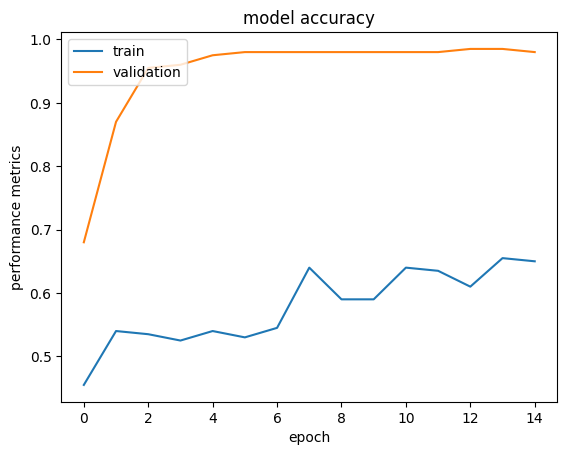

Epoch 1/15
10/13 [======================>.......] - ETA: 0s - loss: 1.0452 - binary_accuracy: 0.5125 - recall_m: 0.4733 - precision_m: 0.0833 - f1_m: 0.1381 

13/13 [==============================] - 2s 35ms/step - loss: 1.0154 - binary_accuracy: 0.5225 - recall_m: 0.4026 - precision_m: 0.0737 - f1_m: 0.1216 - val_loss: 0.7041 - val_binary_accuracy: 0.3550 - val_recall_m: 0.7513 - val_precision_m: 0.0923 - val_f1_m: 0.1594
Epoch 2/15
 9/13 [===================>..........] - ETA: 0s - loss: 0.7810 - binary_accuracy: 0.5729 - recall_m: 0.6045 - precision_m: 0.1133 - f1_m: 0.1814            

13/13 [==============================] - 0s 13ms/step - loss: 0.7451 - binary_accuracy: 0.5650 - recall_m: 0.6108 - precision_m: 0.1018 - f1_m: 0.1671 - val_loss: 0.7002 - val_binary_accuracy: 0.3825 - val_recall_m: 0.8590 - val_precision_m: 0.1113 - val_f1_m: 0.1914
Epoch 3/15
11/13 [========================>.....] - ETA: 0s - loss: 0.6055 - binary_accuracy: 0.6023 - recall_m: 0.7879 - precision_m: 0.1578 - f1_m: 0.2552

13/13 [==============================] - 0s 13ms/step - loss: 0.6254 - binary_accuracy: 0.5825 - recall_m: 0.6667 - precision_m: 0.1335 - f1_m: 0.2159 - val_loss: 0.6927 - val_binary_accuracy: 0.4900 - val_recall_m: 0.8974 - val_precision_m: 0.1350 - val_f1_m: 0.2271
Epoch 4/15
11/13 [========================>.....] - ETA: 0s - loss: 0.5669 - binary_accuracy: 0.5966 - recall_m: 0.8333 - precision_m: 0.1618 - f1_m: 0.2637

13/13 [==============================] - 0s 11ms/step - loss: 0.5539 - binary_accuracy: 0.5975 - recall_m: 0.7821 - precision_m: 0.1471 - f1_m: 0.2413 - val_loss: 0.6776 - val_binary_accuracy: 0.6625 - val_recall_m: 0.8974 - val_precision_m: 0.1885 - val_f1_m: 0.3002
Epoch 5/15
10/13 [======================>.......] - ETA: 0s - loss: 0.5104 - binary_accuracy: 0.6250 - recall_m: 0.8833 - precision_m: 0.1842 - f1_m: 0.2965

13/13 [==============================] - 0s 13ms/step - loss: 0.5063 - binary_accuracy: 0.6150 - recall_m: 0.8333 - precision_m: 0.1564 - f1_m: 0.2547 - val_loss: 0.6570 - val_binary_accuracy: 0.8875 - val_recall_m: 0.8974 - val_precision_m: 0.3989 - val_f1_m: 0.5290
Epoch 6/15
10/13 [======================>.......] - ETA: 0s - loss: 0.4646 - binary_accuracy: 0.6187 - recall_m: 1.0000 - precision_m: 0.1759 - f1_m: 0.2891

13/13 [==============================] - 0s 12ms/step - loss: 0.4418 - binary_accuracy: 0.6275 - recall_m: 1.0000 - precision_m: 0.1710 - f1_m: 0.2834 - val_loss: 0.6348 - val_binary_accuracy: 0.9575 - val_recall_m: 0.8821 - val_precision_m: 0.6247 - val_f1_m: 0.7059
Epoch 7/15
10/13 [======================>.......] - ETA: 0s - loss: 0.4384 - binary_accuracy: 0.6844 - recall_m: 0.9467 - precision_m: 0.2251 - f1_m: 0.3390

13/13 [==============================] - 0s 12ms/step - loss: 0.4600 - binary_accuracy: 0.6625 - recall_m: 0.8436 - precision_m: 0.1915 - f1_m: 0.2924 - val_loss: 0.6144 - val_binary_accuracy: 0.9775 - val_recall_m: 0.8244 - val_precision_m: 0.8115 - val_f1_m: 0.7970
Epoch 8/15
 8/13 [=================>............] - ETA: 0s - loss: 0.4148 - binary_accuracy: 0.6133 - recall_m: 1.0000 - precision_m: 0.1426 - f1_m: 0.2389

13/13 [==============================] - 0s 13ms/step - loss: 0.4392 - binary_accuracy: 0.6600 - recall_m: 0.9038 - precision_m: 0.2224 - f1_m: 0.3271 - val_loss: 0.5952 - val_binary_accuracy: 0.9775 - val_recall_m: 0.7410 - val_precision_m: 0.8590 - val_f1_m: 0.7709
Epoch 9/15
 9/13 [===================>..........] - ETA: 0s - loss: 0.4250 - binary_accuracy: 0.6771 - recall_m: 0.8333 - precision_m: 0.1723 - f1_m: 0.2777

13/13 [==============================] - 0s 13ms/step - loss: 0.4111 - binary_accuracy: 0.6975 - recall_m: 0.8462 - precision_m: 0.1996 - f1_m: 0.3128 - val_loss: 0.5797 - val_binary_accuracy: 0.9800 - val_recall_m: 0.7449 - val_precision_m: 0.8846 - val_f1_m: 0.7852
Epoch 10/15
 9/13 [===================>..........] - ETA: 0s - loss: 0.3894 - binary_accuracy: 0.7431 - recall_m: 0.7778 - precision_m: 0.2834 - f1_m: 0.3799

13/13 [==============================] - 0s 12ms/step - loss: 0.3805 - binary_accuracy: 0.7150 - recall_m: 0.7692 - precision_m: 0.2393 - f1_m: 0.3298 - val_loss: 0.5628 - val_binary_accuracy: 0.9800 - val_recall_m: 0.7449 - val_precision_m: 0.8846 - val_f1_m: 0.7852
Epoch 11/15
 9/13 [===================>..........] - ETA: 0s - loss: 0.4357 - binary_accuracy: 0.7083 - recall_m: 0.8333 - precision_m: 0.2008 - f1_m: 0.3124

13/13 [==============================] - 0s 12ms/step - loss: 0.4063 - binary_accuracy: 0.7300 - recall_m: 0.8846 - precision_m: 0.2336 - f1_m: 0.3533 - val_loss: 0.5433 - val_binary_accuracy: 0.9675 - val_recall_m: 0.5821 - val_precision_m: 0.8462 - val_f1_m: 0.6707
Epoch 12/15
10/13 [======================>.......] - ETA: 0s - loss: 0.3159 - binary_accuracy: 0.7750 - recall_m: 1.0000 - precision_m: 0.2370 - f1_m: 0.3596

13/13 [==============================] - 0s 14ms/step - loss: 0.3125 - binary_accuracy: 0.7900 - recall_m: 1.0000 - precision_m: 0.2849 - f1_m: 0.4167 - val_loss: 0.5257 - val_binary_accuracy: 0.9625 - val_recall_m: 0.4795 - val_precision_m: 0.6923 - val_f1_m: 0.5553
Epoch 13/15
10/13 [======================>.......] - ETA: 0s - loss: 0.3107 - binary_accuracy: 0.7656 - recall_m: 1.0000 - precision_m: 0.2617 - f1_m: 0.4018

13/13 [==============================] - 0s 14ms/step - loss: 0.3136 - binary_accuracy: 0.7750 - recall_m: 1.0000 - precision_m: 0.2711 - f1_m: 0.4152 - val_loss: 0.5042 - val_binary_accuracy: 0.9550 - val_recall_m: 0.4256 - val_precision_m: 0.6923 - val_f1_m: 0.5018
Epoch 14/15
 8/13 [=================>............] - ETA: 0s - loss: 0.3480 - binary_accuracy: 0.7812 - recall_m: 0.7500 - precision_m: 0.2663 - f1_m: 0.3508

13/13 [==============================] - 0s 15ms/step - loss: 0.3292 - binary_accuracy: 0.7850 - recall_m: 0.8462 - precision_m: 0.2917 - f1_m: 0.3923 - val_loss: 0.4825 - val_binary_accuracy: 0.9500 - val_recall_m: 0.3910 - val_precision_m: 0.6154 - val_f1_m: 0.4615
Epoch 15/15
10/13 [======================>.......] - ETA: 0s - loss: 0.3135 - binary_accuracy: 0.8188 - recall_m: 0.8667 - precision_m: 0.3467 - f1_m: 0.4849

531/531 [==============================] - 1s 2ms/step
Current date: 2022-02-23 00:00:00 (1/12)


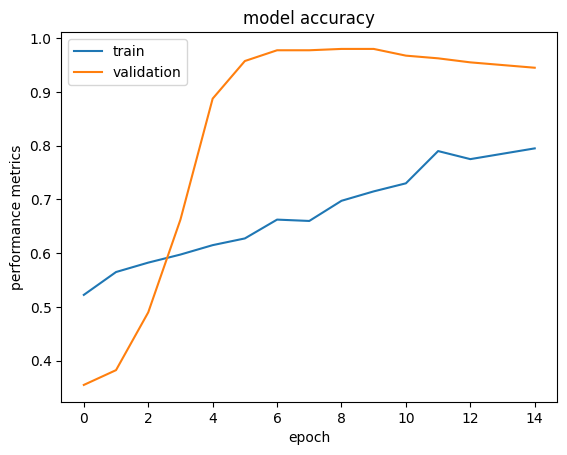

Epoch 1/15
10/19 [==============>...............] - ETA: 0s - loss: 0.8500 - binary_accuracy: 0.5031 - recall_m: 0.5833 - precision_m: 0.0942 - f1_m: 0.1571 

19/19 [==============================] - 2s 33ms/step - loss: 0.9439 - binary_accuracy: 0.4833 - recall_m: 0.5348 - precision_m: 0.1035 - f1_m: 0.1651 - val_loss: 0.6936 - val_binary_accuracy: 0.5083 - val_recall_m: 0.8167 - val_precision_m: 0.1408 - val_f1_m: 0.2334
Epoch 2/15
14/19 [=====================>........] - ETA: 0s - loss: 0.7264 - binary_accuracy: 0.5179 - recall_m: 0.6607 - precision_m: 0.1399 - f1_m: 0.2207

19/19 [==============================] - 0s 19ms/step - loss: 0.6980 - binary_accuracy: 0.5200 - recall_m: 0.6228 - precision_m: 0.1426 - f1_m: 0.2237 - val_loss: 0.7015 - val_binary_accuracy: 0.4050 - val_recall_m: 0.9825 - val_precision_m: 0.1373 - val_f1_m: 0.2345
Epoch 3/15
15/19 [======================>.......] - ETA: 0s - loss: 0.5332 - binary_accuracy: 0.5708 - recall_m: 0.7833 - precision_m: 0.1605 - f1_m: 0.2609

19/19 [==============================] - 0s 13ms/step - loss: 0.5736 - binary_accuracy: 0.5650 - recall_m: 0.7697 - precision_m: 0.1621 - f1_m: 0.2600 - val_loss: 0.6908 - val_binary_accuracy: 0.5200 - val_recall_m: 1.0000 - val_precision_m: 0.1655 - val_f1_m: 0.2766
Epoch 4/15
14/19 [=====================>........] - ETA: 0s - loss: 0.5503 - binary_accuracy: 0.6116 - recall_m: 0.8821 - precision_m: 0.2165 - f1_m: 0.3422

19/19 [==============================] - 0s 14ms/step - loss: 0.5458 - binary_accuracy: 0.5967 - recall_m: 0.8605 - precision_m: 0.1871 - f1_m: 0.3005 - val_loss: 0.6769 - val_binary_accuracy: 0.6383 - val_recall_m: 1.0000 - val_precision_m: 0.2056 - val_f1_m: 0.3319
Epoch 5/15
14/19 [=====================>........] - ETA: 0s - loss: 0.4747 - binary_accuracy: 0.6049 - recall_m: 0.8274 - precision_m: 0.1833 - f1_m: 0.2897

19/19 [==============================] - 0s 14ms/step - loss: 0.4807 - binary_accuracy: 0.6133 - recall_m: 0.8377 - precision_m: 0.1928 - f1_m: 0.3026 - val_loss: 0.6617 - val_binary_accuracy: 0.7267 - val_recall_m: 1.0000 - val_precision_m: 0.2600 - val_f1_m: 0.3969
Epoch 6/15
16/19 [========================>.....] - ETA: 0s - loss: 0.4619 - binary_accuracy: 0.6367 - recall_m: 0.8906 - precision_m: 0.2094 - f1_m: 0.3292

19/19 [==============================] - 0s 18ms/step - loss: 0.4682 - binary_accuracy: 0.6300 - recall_m: 0.8991 - precision_m: 0.2055 - f1_m: 0.3229 - val_loss: 0.6448 - val_binary_accuracy: 0.8033 - val_recall_m: 1.0000 - val_precision_m: 0.3327 - val_f1_m: 0.4795
Epoch 7/15
17/19 [=========================>....] - ETA: 0s - loss: 0.4183 - binary_accuracy: 0.6746 - recall_m: 0.9853 - precision_m: 0.2330 - f1_m: 0.3609

19/19 [==============================] - 0s 13ms/step - loss: 0.4189 - binary_accuracy: 0.6717 - recall_m: 0.9868 - precision_m: 0.2323 - f1_m: 0.3614 - val_loss: 0.6193 - val_binary_accuracy: 0.8917 - val_recall_m: 1.0000 - val_precision_m: 0.4831 - val_f1_m: 0.6228
Epoch 8/15
15/19 [======================>.......] - ETA: 0s - loss: 0.4225 - binary_accuracy: 0.6896 - recall_m: 0.9667 - precision_m: 0.2379 - f1_m: 0.3669

19/19 [==============================] - 0s 17ms/step - loss: 0.4277 - binary_accuracy: 0.6817 - recall_m: 0.9737 - precision_m: 0.2363 - f1_m: 0.3649 - val_loss: 0.5931 - val_binary_accuracy: 0.9450 - val_recall_m: 0.9807 - val_precision_m: 0.6763 - val_f1_m: 0.7684
Epoch 9/15
15/19 [======================>.......] - ETA: 0s - loss: 0.3838 - binary_accuracy: 0.7188 - recall_m: 0.9200 - precision_m: 0.2621 - f1_m: 0.3811

19/19 [==============================] - 0s 18ms/step - loss: 0.3822 - binary_accuracy: 0.7233 - recall_m: 0.9237 - precision_m: 0.2730 - f1_m: 0.3948 - val_loss: 0.5638 - val_binary_accuracy: 0.9667 - val_recall_m: 0.9632 - val_precision_m: 0.7820 - val_f1_m: 0.8403
Epoch 10/15
15/19 [======================>.......] - ETA: 0s - loss: 0.3550 - binary_accuracy: 0.7250 - recall_m: 0.9111 - precision_m: 0.2738 - f1_m: 0.3960

19/19 [==============================] - 0s 18ms/step - loss: 0.3503 - binary_accuracy: 0.7333 - recall_m: 0.9298 - precision_m: 0.2838 - f1_m: 0.4137 - val_loss: 0.5332 - val_binary_accuracy: 0.9817 - val_recall_m: 0.8816 - val_precision_m: 0.8632 - val_f1_m: 0.8584
Epoch 11/15
14/19 [=====================>........] - ETA: 0s - loss: 0.3242 - binary_accuracy: 0.7924 - recall_m: 0.9286 - precision_m: 0.3564 - f1_m: 0.4957

19/19 [==============================] - 0s 18ms/step - loss: 0.3315 - binary_accuracy: 0.7783 - recall_m: 0.8947 - precision_m: 0.3167 - f1_m: 0.4476 - val_loss: 0.5082 - val_binary_accuracy: 0.9833 - val_recall_m: 0.8640 - val_precision_m: 0.9079 - val_f1_m: 0.8771
Epoch 12/15
13/19 [===================>..........] - ETA: 0s - loss: 0.3123 - binary_accuracy: 0.7740 - recall_m: 1.0000 - precision_m: 0.3127 - f1_m: 0.4641

19/19 [==============================] - 0s 12ms/step - loss: 0.3292 - binary_accuracy: 0.7700 - recall_m: 0.9781 - precision_m: 0.3116 - f1_m: 0.4594 - val_loss: 0.4805 - val_binary_accuracy: 0.9833 - val_recall_m: 0.8158 - val_precision_m: 0.8684 - val_f1_m: 0.8293
Epoch 13/15
11/19 [================>.............] - ETA: 0s - loss: 0.2757 - binary_accuracy: 0.8210 - recall_m: 0.9091 - precision_m: 0.3816 - f1_m: 0.5256            

19/19 [==============================] - 0s 10ms/step - loss: 0.2920 - binary_accuracy: 0.8133 - recall_m: 0.8947 - precision_m: 0.3866 - f1_m: 0.5192 - val_loss: 0.4562 - val_binary_accuracy: 0.9883 - val_recall_m: 0.8553 - val_precision_m: 0.8816 - val_f1_m: 0.8644
Epoch 14/15
11/19 [================>.............] - ETA: 0s - loss: 0.2805 - binary_accuracy: 0.7784 - recall_m: 0.9545 - precision_m: 0.2968 - f1_m: 0.4249

19/19 [==============================] - 0s 10ms/step - loss: 0.2867 - binary_accuracy: 0.8100 - recall_m: 0.9211 - precision_m: 0.3711 - f1_m: 0.4992 - val_loss: 0.4322 - val_binary_accuracy: 0.9883 - val_recall_m: 0.8798 - val_precision_m: 0.9342 - val_f1_m: 0.8984
Epoch 15/15
11/19 [================>.............] - ETA: 0s - loss: 0.2941 - binary_accuracy: 0.8409 - recall_m: 0.9848 - precision_m: 0.4171 - f1_m: 0.5545

457/457 [==============================] - 1s 2ms/step
Current date: 2022-02-24 00:00:00 (2/12)


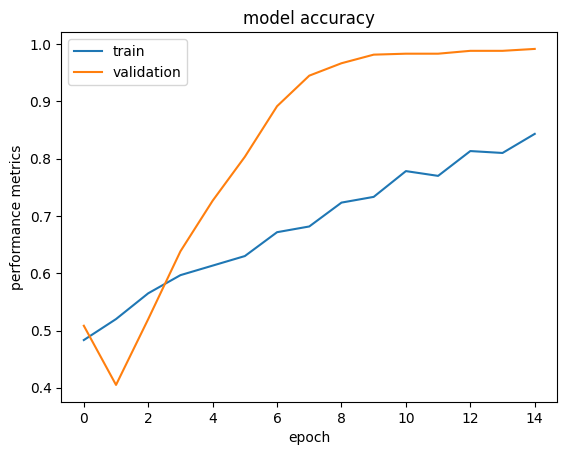

Epoch 1/15
22/25 [=========================>....] - ETA: 0s - loss: 0.9496 - binary_accuracy: 0.5341 - recall_m: 0.5671 - precision_m: 0.1362 - f1_m: 0.2110

25/25 [==============================] - 3s 19ms/step - loss: 0.9131 - binary_accuracy: 0.5312 - recall_m: 0.6057 - precision_m: 0.1335 - f1_m: 0.2095 - val_loss: 0.5994 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0100 - val_precision_m: 0.0400 - val_f1_m: 0.0160
Epoch 2/15
24/25 [===========================>..] - ETA: 0s - loss: 0.6449 - binary_accuracy: 0.6055 - recall_m: 0.7596 - precision_m: 0.1852 - f1_m: 0.2860

25/25 [==============================] - 0s 8ms/step - loss: 0.6342 - binary_accuracy: 0.6062 - recall_m: 0.7692 - precision_m: 0.1896 - f1_m: 0.2927 - val_loss: 0.4993 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/15
24/25 [===========================>..] - ETA: 0s - loss: 0.5910 - binary_accuracy: 0.6471 - recall_m: 0.8256 - precision_m: 0.2165 - f1_m: 0.3272

25/25 [==============================] - 0s 8ms/step - loss: 0.5914 - binary_accuracy: 0.6488 - recall_m: 0.8246 - precision_m: 0.2202 - f1_m: 0.3319 - val_loss: 0.4275 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/15
25/25 [==============================] - ETA: 0s - loss: 0.4801 - binary_accuracy: 0.6913 - recall_m: 0.9093 - precision_m: 0.2554 - f1_m: 0.3830

25/25 [==============================] - 0s 8ms/step - loss: 0.4801 - binary_accuracy: 0.6913 - recall_m: 0.9093 - precision_m: 0.2554 - f1_m: 0.3830 - val_loss: 0.3797 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 5/15
25/25 [==============================] - ETA: 0s - loss: 0.4432 - binary_accuracy: 0.7312 - recall_m: 0.9280 - precision_m: 0.2933 - f1_m: 0.4261

25/25 [==============================] - 0s 8ms/step - loss: 0.4432 - binary_accuracy: 0.7312 - recall_m: 0.9280 - precision_m: 0.2933 - f1_m: 0.4261 - val_loss: 0.3477 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 6/15
25/25 [==============================] - ETA: 0s - loss: 0.3944 - binary_accuracy: 0.7362 - recall_m: 0.9170 - precision_m: 0.2938 - f1_m: 0.4307

25/25 [==============================] - 0s 8ms/step - loss: 0.3944 - binary_accuracy: 0.7362 - recall_m: 0.9170 - precision_m: 0.2938 - f1_m: 0.4307 - val_loss: 0.3256 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 7/15
25/25 [==============================] - ETA: 0s - loss: 0.4022 - binary_accuracy: 0.7625 - recall_m: 0.8600 - precision_m: 0.3187 - f1_m: 0.4437

25/25 [==============================] - 0s 8ms/step - loss: 0.4022 - binary_accuracy: 0.7625 - recall_m: 0.8600 - precision_m: 0.3187 - f1_m: 0.4437 - val_loss: 0.3083 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 8/15
24/25 [===========================>..] - ETA: 0s - loss: 0.3721 - binary_accuracy: 0.7812 - recall_m: 0.9045 - precision_m: 0.3339 - f1_m: 0.4672

25/25 [==============================] - 0s 8ms/step - loss: 0.3709 - binary_accuracy: 0.7837 - recall_m: 0.9083 - precision_m: 0.3405 - f1_m: 0.4752 - val_loss: 0.2944 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 9/15
25/25 [==============================] - ETA: 0s - loss: 0.2895 - binary_accuracy: 0.8150 - recall_m: 0.9476 - precision_m: 0.3941 - f1_m: 0.5351

25/25 [==============================] - 0s 8ms/step - loss: 0.2895 - binary_accuracy: 0.8150 - recall_m: 0.9476 - precision_m: 0.3941 - f1_m: 0.5351 - val_loss: 0.2825 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 10/15
25/25 [==============================] - ETA: 0s - loss: 0.3266 - binary_accuracy: 0.8213 - recall_m: 0.9172 - precision_m: 0.3880 - f1_m: 0.5176

25/25 [==============================] - 0s 8ms/step - loss: 0.3266 - binary_accuracy: 0.8213 - recall_m: 0.9172 - precision_m: 0.3880 - f1_m: 0.5176 - val_loss: 0.2699 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 11/15
25/25 [==============================] - ETA: 0s - loss: 0.3075 - binary_accuracy: 0.8175 - recall_m: 0.9229 - precision_m: 0.3981 - f1_m: 0.5182

25/25 [==============================] - 0s 8ms/step - loss: 0.3075 - binary_accuracy: 0.8175 - recall_m: 0.9229 - precision_m: 0.3981 - f1_m: 0.5182 - val_loss: 0.2584 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 12/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2412 - binary_accuracy: 0.8594 - recall_m: 0.9444 - precision_m: 0.4444 - f1_m: 0.5817

25/25 [==============================] - 0s 8ms/step - loss: 0.2387 - binary_accuracy: 0.8587 - recall_m: 0.9467 - precision_m: 0.4416 - f1_m: 0.5802 - val_loss: 0.2459 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 13/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2150 - binary_accuracy: 0.8867 - recall_m: 0.9479 - precision_m: 0.5294 - f1_m: 0.6585

25/25 [==============================] - 0s 8ms/step - loss: 0.2181 - binary_accuracy: 0.8838 - recall_m: 0.9500 - precision_m: 0.5140 - f1_m: 0.6422 - val_loss: 0.2290 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 14/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2304 - binary_accuracy: 0.8763 - recall_m: 0.9875 - precision_m: 0.4851 - f1_m: 0.6160

25/25 [==============================] - 0s 9ms/step - loss: 0.2289 - binary_accuracy: 0.8763 - recall_m: 0.9880 - precision_m: 0.4737 - f1_m: 0.6047 - val_loss: 0.2173 - val_binary_accuracy: 0.8913 - val_recall_m: 0.0067 - val_precision_m: 0.0400 - val_f1_m: 0.0114
Epoch 15/15
25/25 [==============================] - ETA: 0s - loss: 0.1872 - binary_accuracy: 0.8988 - recall_m: 0.9533 - precision_m: 0.5358 - f1_m: 0.6629

397/397 [==============================] - 1s 2ms/step
Current date: 2022-02-25 00:00:00 (3/12)


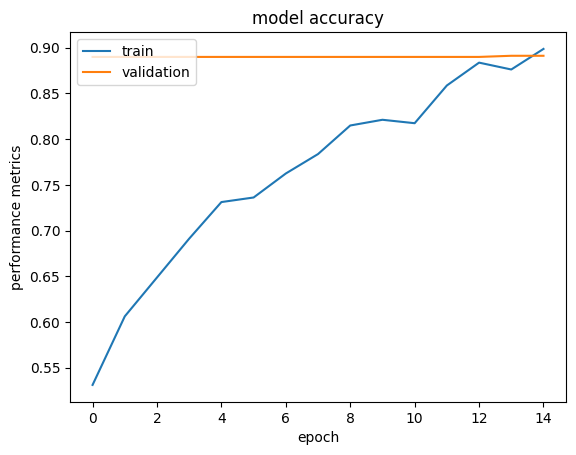

Epoch 1/15
29/32 [==========================>...] - ETA: 0s - loss: 1.0096 - binary_accuracy: 0.5065 - recall_m: 0.4238 - precision_m: 0.1082 - f1_m: 0.1677

32/32 [==============================] - 2s 18ms/step - loss: 1.0067 - binary_accuracy: 0.5110 - recall_m: 0.4153 - precision_m: 0.1075 - f1_m: 0.1659 - val_loss: 0.6638 - val_binary_accuracy: 0.8150 - val_recall_m: 0.4672 - val_precision_m: 0.3154 - val_f1_m: 0.3551
Epoch 2/15
31/32 [============================>.] - ETA: 0s - loss: 0.6851 - binary_accuracy: 0.5938 - recall_m: 0.7564 - precision_m: 0.1896 - f1_m: 0.2911

32/32 [==============================] - 0s 11ms/step - loss: 0.6840 - binary_accuracy: 0.5920 - recall_m: 0.7327 - precision_m: 0.1837 - f1_m: 0.2820 - val_loss: 0.6142 - val_binary_accuracy: 0.8970 - val_recall_m: 0.2547 - val_precision_m: 0.5365 - val_f1_m: 0.3221
Epoch 3/15
31/32 [============================>.] - ETA: 0s - loss: 0.5766 - binary_accuracy: 0.6230 - recall_m: 0.8137 - precision_m: 0.2177 - f1_m: 0.3353

32/32 [==============================] - 0s 9ms/step - loss: 0.5780 - binary_accuracy: 0.6250 - recall_m: 0.8195 - precision_m: 0.2317 - f1_m: 0.3498 - val_loss: 0.5524 - val_binary_accuracy: 0.8930 - val_recall_m: 0.0745 - val_precision_m: 0.2812 - val_f1_m: 0.1152
Epoch 4/15
28/32 [=========================>....] - ETA: 0s - loss: 0.5068 - binary_accuracy: 0.6618 - recall_m: 0.8997 - precision_m: 0.2501 - f1_m: 0.3714

32/32 [==============================] - 0s 11ms/step - loss: 0.5070 - binary_accuracy: 0.6590 - recall_m: 0.9018 - precision_m: 0.2489 - f1_m: 0.3722 - val_loss: 0.4931 - val_binary_accuracy: 0.8840 - val_recall_m: 0.0063 - val_precision_m: 0.0312 - val_f1_m: 0.0104
Epoch 5/15
31/32 [============================>.] - ETA: 0s - loss: 0.4760 - binary_accuracy: 0.6865 - recall_m: 0.8781 - precision_m: 0.2672 - f1_m: 0.3906

32/32 [==============================] - 0s 11ms/step - loss: 0.4803 - binary_accuracy: 0.6860 - recall_m: 0.8663 - precision_m: 0.2692 - f1_m: 0.3909 - val_loss: 0.4535 - val_binary_accuracy: 0.8840 - val_recall_m: 0.0063 - val_precision_m: 0.0312 - val_f1_m: 0.0104
Epoch 6/15
28/32 [=========================>....] - ETA: 0s - loss: 0.4506 - binary_accuracy: 0.7232 - recall_m: 0.8726 - precision_m: 0.2964 - f1_m: 0.4309

32/32 [==============================] - 0s 9ms/step - loss: 0.4498 - binary_accuracy: 0.7240 - recall_m: 0.8573 - precision_m: 0.2829 - f1_m: 0.4145 - val_loss: 0.4198 - val_binary_accuracy: 0.8890 - val_recall_m: 0.0448 - val_precision_m: 0.1875 - val_f1_m: 0.0714
Epoch 7/15
31/32 [============================>.] - ETA: 0s - loss: 0.3977 - binary_accuracy: 0.7540 - recall_m: 0.9159 - precision_m: 0.3249 - f1_m: 0.4586

32/32 [==============================] - 0s 11ms/step - loss: 0.3972 - binary_accuracy: 0.7540 - recall_m: 0.9185 - precision_m: 0.3252 - f1_m: 0.4599 - val_loss: 0.3803 - val_binary_accuracy: 0.8890 - val_recall_m: 0.0396 - val_precision_m: 0.1875 - val_f1_m: 0.0647
Epoch 8/15
30/32 [===========================>..] - ETA: 0s - loss: 0.3549 - binary_accuracy: 0.7906 - recall_m: 0.9699 - precision_m: 0.3671 - f1_m: 0.5055

32/32 [==============================] - 0s 11ms/step - loss: 0.3578 - binary_accuracy: 0.7890 - recall_m: 0.9718 - precision_m: 0.3681 - f1_m: 0.5046 - val_loss: 0.3471 - val_binary_accuracy: 0.8900 - val_recall_m: 0.0448 - val_precision_m: 0.1875 - val_f1_m: 0.0714
Epoch 9/15
30/32 [===========================>..] - ETA: 0s - loss: 0.3366 - binary_accuracy: 0.8052 - recall_m: 0.9792 - precision_m: 0.3809 - f1_m: 0.5147

32/32 [==============================] - 0s 9ms/step - loss: 0.3335 - binary_accuracy: 0.8080 - recall_m: 0.9492 - precision_m: 0.3745 - f1_m: 0.5049 - val_loss: 0.3188 - val_binary_accuracy: 0.8890 - val_recall_m: 0.0370 - val_precision_m: 0.1875 - val_f1_m: 0.0616
Epoch 10/15
29/32 [==========================>...] - ETA: 0s - loss: 0.3043 - binary_accuracy: 0.8179 - recall_m: 0.9195 - precision_m: 0.4138 - f1_m: 0.5418

32/32 [==============================] - 0s 11ms/step - loss: 0.3090 - binary_accuracy: 0.8210 - recall_m: 0.9271 - precision_m: 0.4271 - f1_m: 0.5535 - val_loss: 0.2891 - val_binary_accuracy: 0.8970 - val_recall_m: 0.1094 - val_precision_m: 0.3750 - val_f1_m: 0.1664
Epoch 11/15
30/32 [===========================>..] - ETA: 0s - loss: 0.3108 - binary_accuracy: 0.8375 - recall_m: 0.9375 - precision_m: 0.4236 - f1_m: 0.5460

32/32 [==============================] - 0s 11ms/step - loss: 0.3074 - binary_accuracy: 0.8390 - recall_m: 0.9101 - precision_m: 0.4180 - f1_m: 0.5368 - val_loss: 0.2652 - val_binary_accuracy: 0.9090 - val_recall_m: 0.2333 - val_precision_m: 0.6562 - val_f1_m: 0.3275
Epoch 12/15
30/32 [===========================>..] - ETA: 0s - loss: 0.2919 - binary_accuracy: 0.8594 - recall_m: 0.8729 - precision_m: 0.4686 - f1_m: 0.5686

32/32 [==============================] - 0s 11ms/step - loss: 0.2973 - binary_accuracy: 0.8600 - recall_m: 0.8600 - precision_m: 0.4773 - f1_m: 0.5727 - val_loss: 0.2425 - val_binary_accuracy: 0.9270 - val_recall_m: 0.4401 - val_precision_m: 0.8125 - val_f1_m: 0.5439
Epoch 13/15
30/32 [===========================>..] - ETA: 0s - loss: 0.2622 - binary_accuracy: 0.8698 - recall_m: 0.9355 - precision_m: 0.4854 - f1_m: 0.6195

32/32 [==============================] - 0s 9ms/step - loss: 0.2580 - binary_accuracy: 0.8720 - recall_m: 0.9395 - precision_m: 0.5059 - f1_m: 0.6361 - val_loss: 0.2213 - val_binary_accuracy: 0.9470 - val_recall_m: 0.5818 - val_precision_m: 0.9219 - val_f1_m: 0.6796
Epoch 14/15
30/32 [===========================>..] - ETA: 0s - loss: 0.2644 - binary_accuracy: 0.8792 - recall_m: 0.9322 - precision_m: 0.5136 - f1_m: 0.6290

32/32 [==============================] - 0s 9ms/step - loss: 0.2597 - binary_accuracy: 0.8810 - recall_m: 0.9364 - precision_m: 0.5284 - f1_m: 0.6418 - val_loss: 0.1912 - val_binary_accuracy: 0.9760 - val_recall_m: 0.8062 - val_precision_m: 0.9583 - val_f1_m: 0.8647
Epoch 15/15
30/32 [===========================>..] - ETA: 0s - loss: 0.2118 - binary_accuracy: 0.9083 - recall_m: 0.9278 - precision_m: 0.5803 - f1_m: 0.6896

390/390 [==============================] - 1s 2ms/step
Current date: 2022-02-26 00:00:00 (4/12)


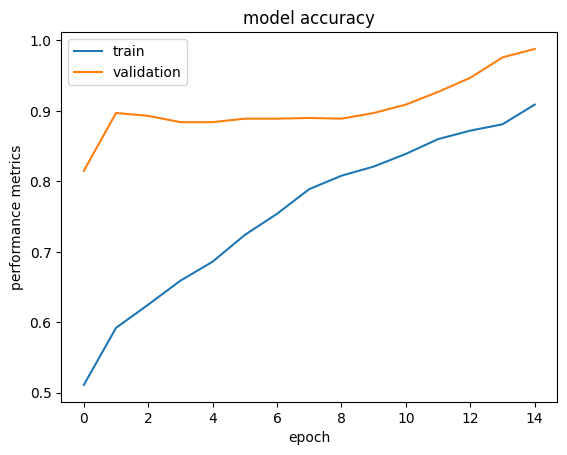

Epoch 1/15
37/38 [============================>.] - ETA: 0s - loss: 0.8985 - binary_accuracy: 0.5084 - recall_m: 0.5721 - precision_m: 0.1329 - f1_m: 0.2077

38/38 [==============================] - 2s 16ms/step - loss: 0.8968 - binary_accuracy: 0.5083 - recall_m: 0.5571 - precision_m: 0.1294 - f1_m: 0.2022 - val_loss: 0.7064 - val_binary_accuracy: 0.3042 - val_recall_m: 0.8927 - val_precision_m: 0.1343 - val_f1_m: 0.2281
Epoch 2/15
37/38 [============================>.] - ETA: 0s - loss: 0.6401 - binary_accuracy: 0.5659 - recall_m: 0.7941 - precision_m: 0.1846 - f1_m: 0.2907

38/38 [==============================] - 0s 9ms/step - loss: 0.6389 - binary_accuracy: 0.5633 - recall_m: 0.7732 - precision_m: 0.1797 - f1_m: 0.2830 - val_loss: 0.6936 - val_binary_accuracy: 0.4842 - val_recall_m: 0.9142 - val_precision_m: 0.1753 - val_f1_m: 0.2864
Epoch 3/15
31/38 [=======================>......] - ETA: 0s - loss: 0.5798 - binary_accuracy: 0.5867 - recall_m: 0.7766 - precision_m: 0.1829 - f1_m: 0.2854

38/38 [==============================] - 0s 8ms/step - loss: 0.5886 - binary_accuracy: 0.5942 - recall_m: 0.7736 - precision_m: 0.1926 - f1_m: 0.2967 - val_loss: 0.6690 - val_binary_accuracy: 0.6750 - val_recall_m: 0.9039 - val_precision_m: 0.2596 - val_f1_m: 0.3881
Epoch 4/15
31/38 [=======================>......] - ETA: 0s - loss: 0.5235 - binary_accuracy: 0.6472 - recall_m: 0.9087 - precision_m: 0.2382 - f1_m: 0.3674

38/38 [==============================] - 0s 9ms/step - loss: 0.5214 - binary_accuracy: 0.6425 - recall_m: 0.8838 - precision_m: 0.2214 - f1_m: 0.3441 - val_loss: 0.6389 - val_binary_accuracy: 0.8100 - val_recall_m: 0.8986 - val_precision_m: 0.3798 - val_f1_m: 0.5092
Epoch 5/15
30/38 [======================>.......] - ETA: 0s - loss: 0.4864 - binary_accuracy: 0.6802 - recall_m: 0.8747 - precision_m: 0.2635 - f1_m: 0.3828

38/38 [==============================] - 0s 10ms/step - loss: 0.4928 - binary_accuracy: 0.6667 - recall_m: 0.8708 - precision_m: 0.2465 - f1_m: 0.3641 - val_loss: 0.5883 - val_binary_accuracy: 0.9267 - val_recall_m: 0.8062 - val_precision_m: 0.6019 - val_f1_m: 0.6617
Epoch 6/15
30/38 [======================>.......] - ETA: 0s - loss: 0.4508 - binary_accuracy: 0.7094 - recall_m: 0.8422 - precision_m: 0.2711 - f1_m: 0.4039

38/38 [==============================] - 0s 8ms/step - loss: 0.4453 - binary_accuracy: 0.7083 - recall_m: 0.8667 - precision_m: 0.2653 - f1_m: 0.3971 - val_loss: 0.5388 - val_binary_accuracy: 0.9475 - val_recall_m: 0.7440 - val_precision_m: 0.7296 - val_f1_m: 0.7075
Epoch 7/15
30/38 [======================>.......] - ETA: 0s - loss: 0.4170 - binary_accuracy: 0.7500 - recall_m: 0.8967 - precision_m: 0.3159 - f1_m: 0.4459

38/38 [==============================] - 0s 10ms/step - loss: 0.4101 - binary_accuracy: 0.7483 - recall_m: 0.8833 - precision_m: 0.3028 - f1_m: 0.4298 - val_loss: 0.4860 - val_binary_accuracy: 0.9617 - val_recall_m: 0.7370 - val_precision_m: 0.8355 - val_f1_m: 0.7559
Epoch 8/15
31/38 [=======================>......] - ETA: 0s - loss: 0.3526 - binary_accuracy: 0.7853 - recall_m: 0.9801 - precision_m: 0.3448 - f1_m: 0.4843

38/38 [==============================] - 0s 9ms/step - loss: 0.3595 - binary_accuracy: 0.7892 - recall_m: 0.9537 - precision_m: 0.3450 - f1_m: 0.4817 - val_loss: 0.4426 - val_binary_accuracy: 0.9592 - val_recall_m: 0.7246 - val_precision_m: 0.8092 - val_f1_m: 0.7278
Epoch 9/15
30/38 [======================>.......] - ETA: 0s - loss: 0.3394 - binary_accuracy: 0.8094 - recall_m: 0.9691 - precision_m: 0.3830 - f1_m: 0.5324

38/38 [==============================] - 0s 10ms/step - loss: 0.3443 - binary_accuracy: 0.8067 - recall_m: 0.9756 - precision_m: 0.3729 - f1_m: 0.5203 - val_loss: 0.3894 - val_binary_accuracy: 0.9725 - val_recall_m: 0.7830 - val_precision_m: 0.8645 - val_f1_m: 0.7943
Epoch 10/15
38/38 [==============================] - ETA: 0s - loss: 0.3085 - binary_accuracy: 0.8300 - recall_m: 0.9480 - precision_m: 0.4044 - f1_m: 0.5414

38/38 [==============================] - 1s 14ms/step - loss: 0.3085 - binary_accuracy: 0.8300 - recall_m: 0.9480 - precision_m: 0.4044 - f1_m: 0.5414 - val_loss: 0.3407 - val_binary_accuracy: 0.9742 - val_recall_m: 0.8036 - val_precision_m: 0.8715 - val_f1_m: 0.8126
Epoch 11/15
35/38 [==========================>...] - ETA: 0s - loss: 0.2875 - binary_accuracy: 0.8357 - recall_m: 0.9752 - precision_m: 0.4124 - f1_m: 0.5458

38/38 [==============================] - 0s 12ms/step - loss: 0.2891 - binary_accuracy: 0.8383 - recall_m: 0.9706 - precision_m: 0.4227 - f1_m: 0.5555 - val_loss: 0.3000 - val_binary_accuracy: 0.9842 - val_recall_m: 0.8655 - val_precision_m: 0.8978 - val_f1_m: 0.8701
Epoch 12/15
34/38 [=========================>....] - ETA: 0s - loss: 0.2689 - binary_accuracy: 0.8631 - recall_m: 0.9657 - precision_m: 0.4626 - f1_m: 0.5984

38/38 [==============================] - 0s 13ms/step - loss: 0.2692 - binary_accuracy: 0.8617 - recall_m: 0.9693 - precision_m: 0.4601 - f1_m: 0.5968 - val_loss: 0.2626 - val_binary_accuracy: 0.9867 - val_recall_m: 0.9096 - val_precision_m: 0.8772 - val_f1_m: 0.8841
Epoch 13/15
36/38 [===========================>..] - ETA: 0s - loss: 0.2910 - binary_accuracy: 0.8594 - recall_m: 0.9366 - precision_m: 0.4464 - f1_m: 0.5771

38/38 [==============================] - 0s 12ms/step - loss: 0.2921 - binary_accuracy: 0.8600 - recall_m: 0.9399 - precision_m: 0.4479 - f1_m: 0.5781 - val_loss: 0.2207 - val_binary_accuracy: 0.9917 - val_recall_m: 0.9355 - val_precision_m: 0.8991 - val_f1_m: 0.9122
Epoch 14/15
37/38 [============================>.] - ETA: 0s - loss: 0.2655 - binary_accuracy: 0.8826 - recall_m: 0.9088 - precision_m: 0.4875 - f1_m: 0.6084

38/38 [==============================] - 0s 12ms/step - loss: 0.2629 - binary_accuracy: 0.8842 - recall_m: 0.9112 - precision_m: 0.5010 - f1_m: 0.6187 - val_loss: 0.1903 - val_binary_accuracy: 0.9925 - val_recall_m: 0.9408 - val_precision_m: 0.8980 - val_f1_m: 0.9140
Epoch 15/15
34/38 [=========================>....] - ETA: 0s - loss: 0.2216 - binary_accuracy: 0.8989 - recall_m: 0.9853 - precision_m: 0.5459 - f1_m: 0.6699

475/475 [==============================] - 1s 2ms/step
Current date: 2022-02-27 00:00:00 (5/12)


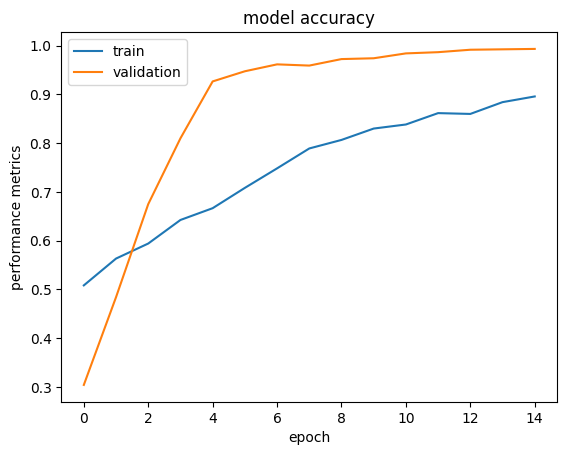

Epoch 1/15
39/44 [=========================>....] - ETA: 0s - loss: 0.7952 - binary_accuracy: 0.5032 - recall_m: 0.6278 - precision_m: 0.1305 - f1_m: 0.2075

44/44 [==============================] - 3s 16ms/step - loss: 0.7986 - binary_accuracy: 0.5100 - recall_m: 0.6431 - precision_m: 0.1448 - f1_m: 0.2273 - val_loss: 0.7683 - val_binary_accuracy: 0.1179 - val_recall_m: 1.0000 - val_precision_m: 0.1159 - val_f1_m: 0.2035
Epoch 2/15
38/44 [========================>.....] - ETA: 0s - loss: 0.6043 - binary_accuracy: 0.5650 - recall_m: 0.8123 - precision_m: 0.1946 - f1_m: 0.3033

44/44 [==============================] - 0s 10ms/step - loss: 0.5958 - binary_accuracy: 0.5693 - recall_m: 0.8095 - precision_m: 0.1903 - f1_m: 0.2980 - val_loss: 0.8499 - val_binary_accuracy: 0.1164 - val_recall_m: 1.0000 - val_precision_m: 0.1156 - val_f1_m: 0.2032
Epoch 3/15
39/44 [=========================>....] - ETA: 0s - loss: 0.5037 - binary_accuracy: 0.6218 - recall_m: 0.9500 - precision_m: 0.2279 - f1_m: 0.3543

44/44 [==============================] - 0s 10ms/step - loss: 0.5015 - binary_accuracy: 0.6229 - recall_m: 0.9481 - precision_m: 0.2293 - f1_m: 0.3569 - val_loss: 0.8474 - val_binary_accuracy: 0.1171 - val_recall_m: 1.0000 - val_precision_m: 0.1156 - val_f1_m: 0.2032
Epoch 4/15
38/44 [========================>.....] - ETA: 0s - loss: 0.4822 - binary_accuracy: 0.6414 - recall_m: 0.9325 - precision_m: 0.2419 - f1_m: 0.3710

44/44 [==============================] - 0s 9ms/step - loss: 0.4840 - binary_accuracy: 0.6421 - recall_m: 0.9258 - precision_m: 0.2365 - f1_m: 0.3629 - val_loss: 0.8070 - val_binary_accuracy: 0.1571 - val_recall_m: 1.0000 - val_precision_m: 0.1204 - val_f1_m: 0.2105
Epoch 5/15
40/44 [==========================>...] - ETA: 0s - loss: 0.4369 - binary_accuracy: 0.6820 - recall_m: 0.9408 - precision_m: 0.2567 - f1_m: 0.3891

44/44 [==============================] - 0s 9ms/step - loss: 0.4411 - binary_accuracy: 0.6836 - recall_m: 0.9333 - precision_m: 0.2620 - f1_m: 0.3946 - val_loss: 0.7632 - val_binary_accuracy: 0.2629 - val_recall_m: 1.0000 - val_precision_m: 0.1355 - val_f1_m: 0.2335
Epoch 6/15
38/44 [========================>.....] - ETA: 0s - loss: 0.4093 - binary_accuracy: 0.7138 - recall_m: 0.9499 - precision_m: 0.2829 - f1_m: 0.4178

44/44 [==============================] - 0s 9ms/step - loss: 0.4095 - binary_accuracy: 0.7186 - recall_m: 0.9522 - precision_m: 0.2917 - f1_m: 0.4277 - val_loss: 0.6917 - val_binary_accuracy: 0.4857 - val_recall_m: 1.0000 - val_precision_m: 0.1824 - val_f1_m: 0.3008
Epoch 7/15
39/44 [=========================>....] - ETA: 0s - loss: 0.3869 - binary_accuracy: 0.7436 - recall_m: 0.9090 - precision_m: 0.3165 - f1_m: 0.4505

44/44 [==============================] - 0s 9ms/step - loss: 0.3837 - binary_accuracy: 0.7443 - recall_m: 0.9193 - precision_m: 0.3112 - f1_m: 0.4475 - val_loss: 0.6186 - val_binary_accuracy: 0.6879 - val_recall_m: 1.0000 - val_precision_m: 0.2729 - val_f1_m: 0.4149
Epoch 8/15
40/44 [==========================>...] - ETA: 0s - loss: 0.3635 - binary_accuracy: 0.7695 - recall_m: 0.9742 - precision_m: 0.3375 - f1_m: 0.4795

44/44 [==============================] - 0s 9ms/step - loss: 0.3639 - binary_accuracy: 0.7671 - recall_m: 0.9481 - precision_m: 0.3312 - f1_m: 0.4706 - val_loss: 0.5377 - val_binary_accuracy: 0.8221 - val_recall_m: 1.0000 - val_precision_m: 0.3999 - val_f1_m: 0.5508
Epoch 9/15
43/44 [============================>.] - ETA: 0s - loss: 0.3296 - binary_accuracy: 0.8089 - recall_m: 0.9261 - precision_m: 0.3795 - f1_m: 0.5159

44/44 [==============================] - 0s 10ms/step - loss: 0.3298 - binary_accuracy: 0.8086 - recall_m: 0.9278 - precision_m: 0.3774 - f1_m: 0.5142 - val_loss: 0.4633 - val_binary_accuracy: 0.9036 - val_recall_m: 1.0000 - val_precision_m: 0.5656 - val_f1_m: 0.6980
Epoch 10/15
38/44 [========================>.....] - ETA: 0s - loss: 0.3114 - binary_accuracy: 0.8199 - recall_m: 0.9609 - precision_m: 0.3904 - f1_m: 0.5319

44/44 [==============================] - 0s 9ms/step - loss: 0.3109 - binary_accuracy: 0.8157 - recall_m: 0.9662 - precision_m: 0.3747 - f1_m: 0.5170 - val_loss: 0.3985 - val_binary_accuracy: 0.9250 - val_recall_m: 1.0000 - val_precision_m: 0.6222 - val_f1_m: 0.7436
Epoch 11/15
35/44 [======================>.......] - ETA: 0s - loss: 0.2865 - binary_accuracy: 0.8455 - recall_m: 0.9111 - precision_m: 0.4284 - f1_m: 0.5559

44/44 [==============================] - 0s 10ms/step - loss: 0.2808 - binary_accuracy: 0.8529 - recall_m: 0.9293 - precision_m: 0.4458 - f1_m: 0.5789 - val_loss: 0.3243 - val_binary_accuracy: 0.9486 - val_recall_m: 1.0000 - val_precision_m: 0.7210 - val_f1_m: 0.8177
Epoch 12/15
36/44 [=======================>......] - ETA: 0s - loss: 0.2550 - binary_accuracy: 0.8611 - recall_m: 0.9722 - precision_m: 0.4566 - f1_m: 0.5958

44/44 [==============================] - 0s 9ms/step - loss: 0.2508 - binary_accuracy: 0.8679 - recall_m: 0.9773 - precision_m: 0.4794 - f1_m: 0.6186 - val_loss: 0.2544 - val_binary_accuracy: 0.9707 - val_recall_m: 1.0000 - val_precision_m: 0.8113 - val_f1_m: 0.8827
Epoch 13/15
36/44 [=======================>......] - ETA: 0s - loss: 0.2367 - binary_accuracy: 0.8785 - recall_m: 0.9757 - precision_m: 0.4918 - f1_m: 0.6198

44/44 [==============================] - 0s 10ms/step - loss: 0.2393 - binary_accuracy: 0.8793 - recall_m: 0.9756 - precision_m: 0.5043 - f1_m: 0.6334 - val_loss: 0.2080 - val_binary_accuracy: 0.9771 - val_recall_m: 1.0000 - val_precision_m: 0.8497 - val_f1_m: 0.9084
Epoch 14/15
40/44 [==========================>...] - ETA: 0s - loss: 0.2169 - binary_accuracy: 0.8883 - recall_m: 0.9825 - precision_m: 0.5091 - f1_m: 0.6490

44/44 [==============================] - 0s 10ms/step - loss: 0.2204 - binary_accuracy: 0.8921 - recall_m: 0.9841 - precision_m: 0.5271 - f1_m: 0.6636 - val_loss: 0.1930 - val_binary_accuracy: 0.9650 - val_recall_m: 1.0000 - val_precision_m: 0.7799 - val_f1_m: 0.8613
Epoch 15/15
40/44 [==========================>...] - ETA: 0s - loss: 0.2057 - binary_accuracy: 0.9000 - recall_m: 0.9574 - precision_m: 0.5353 - f1_m: 0.6584

502/502 [==============================] - 1s 3ms/step
Current date: 2022-02-28 00:00:00 (6/12)


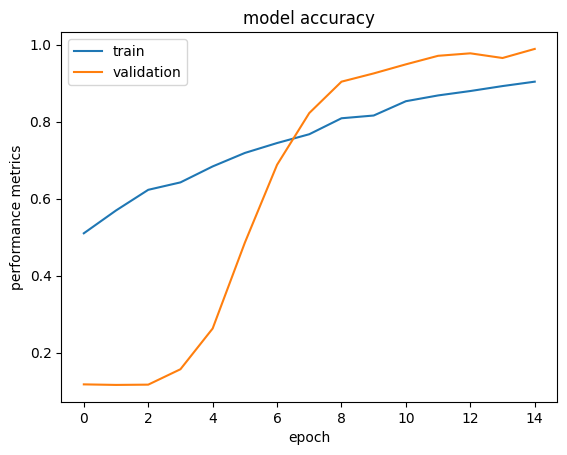

Epoch 1/15
43/50 [========================>.....] - ETA: 0s - loss: 0.8523 - binary_accuracy: 0.5007 - recall_m: 0.6315 - precision_m: 0.1370 - f1_m: 0.2180

50/50 [==============================] - 3s 21ms/step - loss: 0.8409 - binary_accuracy: 0.5075 - recall_m: 0.6418 - precision_m: 0.1411 - f1_m: 0.2248 - val_loss: 0.6745 - val_binary_accuracy: 0.7794 - val_recall_m: 0.6543 - val_precision_m: 0.2972 - val_f1_m: 0.3929
Epoch 2/15
42/50 [========================>.....] - ETA: 0s - loss: 0.5856 - binary_accuracy: 0.5938 - recall_m: 0.8688 - precision_m: 0.2008 - f1_m: 0.3154

50/50 [==============================] - 0s 10ms/step - loss: 0.5919 - binary_accuracy: 0.5975 - recall_m: 0.8485 - precision_m: 0.2034 - f1_m: 0.3165 - val_loss: 0.6224 - val_binary_accuracy: 0.9119 - val_recall_m: 0.3296 - val_precision_m: 0.6225 - val_f1_m: 0.4154
Epoch 3/15
50/50 [==============================] - ETA: 0s - loss: 0.5485 - binary_accuracy: 0.6369 - recall_m: 0.8017 - precision_m: 0.2248 - f1_m: 0.3316

50/50 [==============================] - 1s 10ms/step - loss: 0.5485 - binary_accuracy: 0.6369 - recall_m: 0.8017 - precision_m: 0.2248 - f1_m: 0.3316 - val_loss: 0.5724 - val_binary_accuracy: 0.9169 - val_recall_m: 0.3277 - val_precision_m: 0.6843 - val_f1_m: 0.4264
Epoch 4/15
49/50 [============================>.] - ETA: 0s - loss: 0.4829 - binary_accuracy: 0.6837 - recall_m: 0.8547 - precision_m: 0.2519 - f1_m: 0.3759

50/50 [==============================] - 1s 14ms/step - loss: 0.4805 - binary_accuracy: 0.6837 - recall_m: 0.8576 - precision_m: 0.2515 - f1_m: 0.3759 - val_loss: 0.5284 - val_binary_accuracy: 0.9225 - val_recall_m: 0.3710 - val_precision_m: 0.7027 - val_f1_m: 0.4693
Epoch 5/15
49/50 [============================>.] - ETA: 0s - loss: 0.4543 - binary_accuracy: 0.7232 - recall_m: 0.8776 - precision_m: 0.2825 - f1_m: 0.4104

50/50 [==============================] - 1s 11ms/step - loss: 0.4536 - binary_accuracy: 0.7225 - recall_m: 0.8800 - precision_m: 0.2802 - f1_m: 0.4079 - val_loss: 0.4751 - val_binary_accuracy: 0.9244 - val_recall_m: 0.3524 - val_precision_m: 0.7367 - val_f1_m: 0.4610
Epoch 6/15
41/50 [=======================>......] - ETA: 0s - loss: 0.3787 - binary_accuracy: 0.7797 - recall_m: 0.9668 - precision_m: 0.3321 - f1_m: 0.4732

50/50 [==============================] - 0s 10ms/step - loss: 0.3918 - binary_accuracy: 0.7806 - recall_m: 0.9544 - precision_m: 0.3425 - f1_m: 0.4849 - val_loss: 0.4137 - val_binary_accuracy: 0.9237 - val_recall_m: 0.3364 - val_precision_m: 0.7200 - val_f1_m: 0.4440
Epoch 7/15
44/50 [=========================>....] - ETA: 0s - loss: 0.3999 - binary_accuracy: 0.7820 - recall_m: 0.8639 - precision_m: 0.3330 - f1_m: 0.4620

50/50 [==============================] - 0s 7ms/step - loss: 0.4010 - binary_accuracy: 0.7837 - recall_m: 0.8616 - precision_m: 0.3364 - f1_m: 0.4657 - val_loss: 0.3627 - val_binary_accuracy: 0.9481 - val_recall_m: 0.5893 - val_precision_m: 0.8631 - val_f1_m: 0.6769
Epoch 8/15
46/50 [==========================>...] - ETA: 0s - loss: 0.3524 - binary_accuracy: 0.8057 - recall_m: 0.9212 - precision_m: 0.3864 - f1_m: 0.5173

50/50 [==============================] - 0s 7ms/step - loss: 0.3488 - binary_accuracy: 0.8081 - recall_m: 0.9225 - precision_m: 0.3886 - f1_m: 0.5171 - val_loss: 0.3151 - val_binary_accuracy: 0.9594 - val_recall_m: 0.7083 - val_precision_m: 0.9193 - val_f1_m: 0.7769
Epoch 9/15
46/50 [==========================>...] - ETA: 0s - loss: 0.3266 - binary_accuracy: 0.8247 - recall_m: 0.9171 - precision_m: 0.4018 - f1_m: 0.5261

50/50 [==============================] - 0s 7ms/step - loss: 0.3231 - binary_accuracy: 0.8231 - recall_m: 0.9037 - precision_m: 0.3851 - f1_m: 0.5074 - val_loss: 0.2683 - val_binary_accuracy: 0.9731 - val_recall_m: 0.8290 - val_precision_m: 0.9227 - val_f1_m: 0.8579
Epoch 10/15
47/50 [===========================>..] - ETA: 0s - loss: 0.2882 - binary_accuracy: 0.8650 - recall_m: 0.9171 - precision_m: 0.4612 - f1_m: 0.5888

50/50 [==============================] - 0s 8ms/step - loss: 0.2858 - binary_accuracy: 0.8656 - recall_m: 0.9221 - precision_m: 0.4586 - f1_m: 0.5875 - val_loss: 0.2237 - val_binary_accuracy: 0.9825 - val_recall_m: 0.9066 - val_precision_m: 0.9215 - val_f1_m: 0.9054
Epoch 11/15
46/50 [==========================>...] - ETA: 0s - loss: 0.2712 - binary_accuracy: 0.8662 - recall_m: 0.9367 - precision_m: 0.4851 - f1_m: 0.5956

50/50 [==============================] - 0s 8ms/step - loss: 0.2744 - binary_accuracy: 0.8650 - recall_m: 0.9185 - precision_m: 0.4813 - f1_m: 0.5887 - val_loss: 0.1902 - val_binary_accuracy: 0.9825 - val_recall_m: 0.9462 - val_precision_m: 0.8990 - val_f1_m: 0.9151
Epoch 12/15
46/50 [==========================>...] - ETA: 0s - loss: 0.2396 - binary_accuracy: 0.8859 - recall_m: 0.9399 - precision_m: 0.5138 - f1_m: 0.6386

50/50 [==============================] - 0s 8ms/step - loss: 0.2422 - binary_accuracy: 0.8856 - recall_m: 0.9422 - precision_m: 0.5136 - f1_m: 0.6382 - val_loss: 0.1595 - val_binary_accuracy: 0.9900 - val_recall_m: 0.9893 - val_precision_m: 0.9368 - val_f1_m: 0.9553
Epoch 13/15
47/50 [===========================>..] - ETA: 0s - loss: 0.2374 - binary_accuracy: 0.9023 - recall_m: 0.9216 - precision_m: 0.5530 - f1_m: 0.6612

50/50 [==============================] - 0s 8ms/step - loss: 0.2365 - binary_accuracy: 0.9006 - recall_m: 0.9263 - precision_m: 0.5454 - f1_m: 0.6566 - val_loss: 0.1356 - val_binary_accuracy: 0.9875 - val_recall_m: 0.9933 - val_precision_m: 0.9102 - val_f1_m: 0.9410
Epoch 14/15
47/50 [===========================>..] - ETA: 0s - loss: 0.2008 - binary_accuracy: 0.9096 - recall_m: 0.9496 - precision_m: 0.5644 - f1_m: 0.6818

50/50 [==============================] - 0s 7ms/step - loss: 0.2015 - binary_accuracy: 0.9119 - recall_m: 0.9527 - precision_m: 0.5749 - f1_m: 0.6918 - val_loss: 0.1112 - val_binary_accuracy: 0.9906 - val_recall_m: 1.0000 - val_precision_m: 0.9331 - val_f1_m: 0.9606
Epoch 15/15
46/50 [==========================>...] - ETA: 0s - loss: 0.1777 - binary_accuracy: 0.9239 - recall_m: 0.9629 - precision_m: 0.5966 - f1_m: 0.7063

534/534 [==============================] - 1s 2ms/step
Current date: 2022-03-01 00:00:00 (7/12)


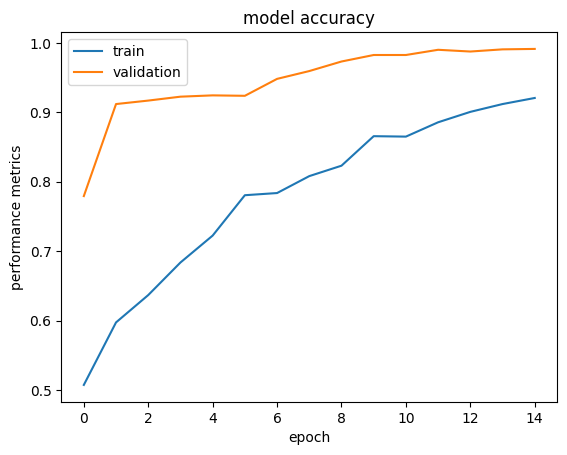

Epoch 1/15
57/57 [==============================] - ETA: 0s - loss: 0.8329 - binary_accuracy: 0.4928 - recall_m: 0.6153 - precision_m: 0.1266 - f1_m: 0.2033

57/57 [==============================] - 3s 15ms/step - loss: 0.8329 - binary_accuracy: 0.4928 - recall_m: 0.6153 - precision_m: 0.1266 - f1_m: 0.2033 - val_loss: 0.8118 - val_binary_accuracy: 0.1072 - val_recall_m: 0.9825 - val_precision_m: 0.1075 - val_f1_m: 0.1889
Epoch 2/15
54/57 [===========================>..] - ETA: 0s - loss: 0.6038 - binary_accuracy: 0.5747 - recall_m: 0.8464 - precision_m: 0.1817 - f1_m: 0.2904

57/57 [==============================] - 1s 9ms/step - loss: 0.5988 - binary_accuracy: 0.5739 - recall_m: 0.8457 - precision_m: 0.1811 - f1_m: 0.2895 - val_loss: 0.8341 - val_binary_accuracy: 0.1100 - val_recall_m: 0.9825 - val_precision_m: 0.1078 - val_f1_m: 0.1893
Epoch 3/15
55/57 [===========================>..] - ETA: 0s - loss: 0.5355 - binary_accuracy: 0.6273 - recall_m: 0.8869 - precision_m: 0.2128 - f1_m: 0.3300

57/57 [==============================] - 1s 10ms/step - loss: 0.5327 - binary_accuracy: 0.6267 - recall_m: 0.8909 - precision_m: 0.2123 - f1_m: 0.3294 - val_loss: 0.7971 - val_binary_accuracy: 0.1617 - val_recall_m: 0.9825 - val_precision_m: 0.1139 - val_f1_m: 0.1988
Epoch 4/15
54/57 [===========================>..] - ETA: 0s - loss: 0.4564 - binary_accuracy: 0.6840 - recall_m: 0.9131 - precision_m: 0.2412 - f1_m: 0.3689

57/57 [==============================] - 1s 13ms/step - loss: 0.4706 - binary_accuracy: 0.6850 - recall_m: 0.8990 - precision_m: 0.2493 - f1_m: 0.3744 - val_loss: 0.7302 - val_binary_accuracy: 0.3522 - val_recall_m: 0.9825 - val_precision_m: 0.1422 - val_f1_m: 0.2410
Epoch 5/15
55/57 [===========================>..] - ETA: 0s - loss: 0.4473 - binary_accuracy: 0.7000 - recall_m: 0.8124 - precision_m: 0.2461 - f1_m: 0.3617

57/57 [==============================] - 1s 13ms/step - loss: 0.4477 - binary_accuracy: 0.7006 - recall_m: 0.8146 - precision_m: 0.2481 - f1_m: 0.3648 - val_loss: 0.6702 - val_binary_accuracy: 0.5511 - val_recall_m: 0.9825 - val_precision_m: 0.1898 - val_f1_m: 0.3078
Epoch 6/15
51/57 [=========================>....] - ETA: 0s - loss: 0.3991 - binary_accuracy: 0.7408 - recall_m: 0.9222 - precision_m: 0.2927 - f1_m: 0.4293

57/57 [==============================] - 1s 13ms/step - loss: 0.3958 - binary_accuracy: 0.7450 - recall_m: 0.9129 - precision_m: 0.2904 - f1_m: 0.4260 - val_loss: 0.5832 - val_binary_accuracy: 0.7633 - val_recall_m: 0.9825 - val_precision_m: 0.3085 - val_f1_m: 0.4547
Epoch 7/15
51/57 [=========================>....] - ETA: 0s - loss: 0.3646 - binary_accuracy: 0.7782 - recall_m: 0.9163 - precision_m: 0.3276 - f1_m: 0.4600

57/57 [==============================] - 1s 13ms/step - loss: 0.3645 - binary_accuracy: 0.7811 - recall_m: 0.9226 - precision_m: 0.3332 - f1_m: 0.4678 - val_loss: 0.4788 - val_binary_accuracy: 0.8928 - val_recall_m: 0.9693 - val_precision_m: 0.4970 - val_f1_m: 0.6333
Epoch 8/15
56/57 [============================>.] - ETA: 0s - loss: 0.3444 - binary_accuracy: 0.7969 - recall_m: 0.9013 - precision_m: 0.3519 - f1_m: 0.4767

57/57 [==============================] - 1s 12ms/step - loss: 0.3439 - binary_accuracy: 0.7978 - recall_m: 0.9031 - precision_m: 0.3633 - f1_m: 0.4859 - val_loss: 0.4007 - val_binary_accuracy: 0.9339 - val_recall_m: 0.9693 - val_precision_m: 0.6280 - val_f1_m: 0.7409
Epoch 9/15
51/57 [=========================>....] - ETA: 0s - loss: 0.3213 - binary_accuracy: 0.8162 - recall_m: 0.9493 - precision_m: 0.3729 - f1_m: 0.5173

57/57 [==============================] - 1s 11ms/step - loss: 0.3231 - binary_accuracy: 0.8156 - recall_m: 0.9444 - precision_m: 0.3797 - f1_m: 0.5206 - val_loss: 0.3371 - val_binary_accuracy: 0.9378 - val_recall_m: 0.9746 - val_precision_m: 0.6373 - val_f1_m: 0.7506
Epoch 10/15
56/57 [============================>.] - ETA: 0s - loss: 0.2913 - binary_accuracy: 0.8510 - recall_m: 0.9463 - precision_m: 0.4237 - f1_m: 0.5628

57/57 [==============================] - 0s 9ms/step - loss: 0.2930 - binary_accuracy: 0.8500 - recall_m: 0.9384 - precision_m: 0.4221 - f1_m: 0.5599 - val_loss: 0.2765 - val_binary_accuracy: 0.9550 - val_recall_m: 0.9781 - val_precision_m: 0.7011 - val_f1_m: 0.7992
Epoch 11/15
56/57 [============================>.] - ETA: 0s - loss: 0.2697 - binary_accuracy: 0.8694 - recall_m: 0.9293 - precision_m: 0.4534 - f1_m: 0.5872

57/57 [==============================] - 0s 9ms/step - loss: 0.2711 - binary_accuracy: 0.8700 - recall_m: 0.9306 - precision_m: 0.4630 - f1_m: 0.5944 - val_loss: 0.2355 - val_binary_accuracy: 0.9539 - val_recall_m: 0.9781 - val_precision_m: 0.6894 - val_f1_m: 0.7929
Epoch 12/15
54/57 [===========================>..] - ETA: 0s - loss: 0.2424 - binary_accuracy: 0.8848 - recall_m: 0.9453 - precision_m: 0.4961 - f1_m: 0.6205

57/57 [==============================] - 1s 9ms/step - loss: 0.2418 - binary_accuracy: 0.8811 - recall_m: 0.9482 - precision_m: 0.4831 - f1_m: 0.6073 - val_loss: 0.1899 - val_binary_accuracy: 0.9717 - val_recall_m: 0.9825 - val_precision_m: 0.7776 - val_f1_m: 0.8502
Epoch 13/15
56/57 [============================>.] - ETA: 0s - loss: 0.2279 - binary_accuracy: 0.8968 - recall_m: 0.9223 - precision_m: 0.5093 - f1_m: 0.6241

57/57 [==============================] - 1s 9ms/step - loss: 0.2295 - binary_accuracy: 0.8961 - recall_m: 0.9061 - precision_m: 0.5004 - f1_m: 0.6132 - val_loss: 0.1515 - val_binary_accuracy: 0.9811 - val_recall_m: 0.9825 - val_precision_m: 0.8411 - val_f1_m: 0.8969
Epoch 14/15
55/57 [===========================>..] - ETA: 0s - loss: 0.2121 - binary_accuracy: 0.9119 - recall_m: 0.9499 - precision_m: 0.5627 - f1_m: 0.6836

57/57 [==============================] - 1s 9ms/step - loss: 0.2125 - binary_accuracy: 0.9133 - recall_m: 0.9517 - precision_m: 0.5692 - f1_m: 0.6888 - val_loss: 0.1366 - val_binary_accuracy: 0.9778 - val_recall_m: 0.9825 - val_precision_m: 0.8173 - val_f1_m: 0.8799
Epoch 15/15
56/57 [============================>.] - ETA: 0s - loss: 0.2174 - binary_accuracy: 0.9012 - recall_m: 0.9589 - precision_m: 0.5251 - f1_m: 0.6557

576/576 [==============================] - 1s 2ms/step
Current date: 2022-03-02 00:00:00 (8/12)


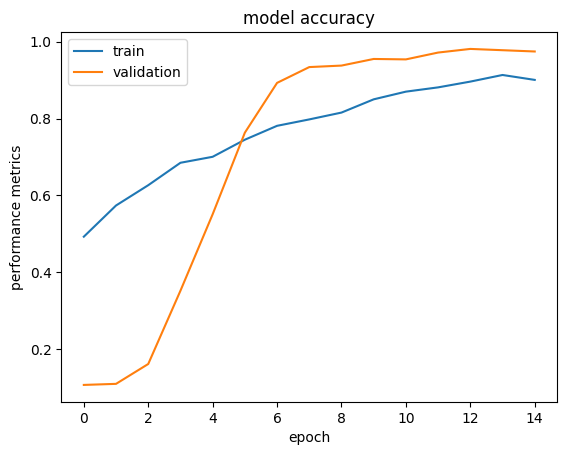

Epoch 1/15
62/63 [============================>.] - ETA: 0s - loss: 0.7428 - binary_accuracy: 0.5585 - recall_m: 0.5254 - precision_m: 0.1352 - f1_m: 0.2081

63/63 [==============================] - 4s 19ms/step - loss: 0.7429 - binary_accuracy: 0.5585 - recall_m: 0.5250 - precision_m: 0.1353 - f1_m: 0.2083 - val_loss: 0.5963 - val_binary_accuracy: 0.8885 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/15
56/63 [=========================>....] - ETA: 0s - loss: 0.5813 - binary_accuracy: 0.6166 - recall_m: 0.7514 - precision_m: 0.1963 - f1_m: 0.2986

63/63 [==============================] - 1s 9ms/step - loss: 0.5807 - binary_accuracy: 0.6255 - recall_m: 0.7657 - precision_m: 0.2057 - f1_m: 0.3090 - val_loss: 0.5137 - val_binary_accuracy: 0.8885 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/15
54/63 [========================>.....] - ETA: 0s - loss: 0.5204 - binary_accuracy: 0.6846 - recall_m: 0.8509 - precision_m: 0.2463 - f1_m: 0.3649

63/63 [==============================] - 1s 9ms/step - loss: 0.5153 - binary_accuracy: 0.6855 - recall_m: 0.8505 - precision_m: 0.2464 - f1_m: 0.3658 - val_loss: 0.4488 - val_binary_accuracy: 0.8895 - val_recall_m: 0.0185 - val_precision_m: 0.0317 - val_f1_m: 0.0204
Epoch 4/15
56/63 [=========================>....] - ETA: 0s - loss: 0.4628 - binary_accuracy: 0.7165 - recall_m: 0.8614 - precision_m: 0.2699 - f1_m: 0.3894

63/63 [==============================] - 1s 9ms/step - loss: 0.4658 - binary_accuracy: 0.7185 - recall_m: 0.8629 - precision_m: 0.2716 - f1_m: 0.3905 - val_loss: 0.4028 - val_binary_accuracy: 0.8920 - val_recall_m: 0.0516 - val_precision_m: 0.1111 - val_f1_m: 0.0630
Epoch 5/15
56/63 [=========================>....] - ETA: 0s - loss: 0.4206 - binary_accuracy: 0.7679 - recall_m: 0.8659 - precision_m: 0.3235 - f1_m: 0.4502

63/63 [==============================] - 1s 9ms/step - loss: 0.4190 - binary_accuracy: 0.7715 - recall_m: 0.8689 - precision_m: 0.3287 - f1_m: 0.4551 - val_loss: 0.3479 - val_binary_accuracy: 0.9000 - val_recall_m: 0.1366 - val_precision_m: 0.3492 - val_f1_m: 0.1810
Epoch 6/15
62/63 [============================>.] - ETA: 0s - loss: 0.3882 - binary_accuracy: 0.7974 - recall_m: 0.8810 - precision_m: 0.3579 - f1_m: 0.4828

63/63 [==============================] - 1s 9ms/step - loss: 0.3880 - binary_accuracy: 0.7985 - recall_m: 0.8829 - precision_m: 0.3642 - f1_m: 0.4887 - val_loss: 0.3050 - val_binary_accuracy: 0.9075 - val_recall_m: 0.2142 - val_precision_m: 0.5212 - val_f1_m: 0.2779
Epoch 7/15
62/63 [============================>.] - ETA: 0s - loss: 0.3744 - binary_accuracy: 0.8221 - recall_m: 0.8834 - precision_m: 0.3833 - f1_m: 0.5103

63/63 [==============================] - 1s 9ms/step - loss: 0.3755 - binary_accuracy: 0.8220 - recall_m: 0.8773 - precision_m: 0.3825 - f1_m: 0.5085 - val_loss: 0.2726 - val_binary_accuracy: 0.9330 - val_recall_m: 0.4471 - val_precision_m: 0.7169 - val_f1_m: 0.5210
Epoch 8/15
54/63 [========================>.....] - ETA: 0s - loss: 0.3607 - binary_accuracy: 0.8351 - recall_m: 0.8754 - precision_m: 0.4171 - f1_m: 0.5291

63/63 [==============================] - 1s 8ms/step - loss: 0.3504 - binary_accuracy: 0.8370 - recall_m: 0.8641 - precision_m: 0.4167 - f1_m: 0.5283 - val_loss: 0.2456 - val_binary_accuracy: 0.9640 - val_recall_m: 0.8107 - val_precision_m: 0.8283 - val_f1_m: 0.7953
Epoch 9/15
57/63 [==========================>...] - ETA: 0s - loss: 0.3082 - binary_accuracy: 0.8498 - recall_m: 0.8835 - precision_m: 0.4353 - f1_m: 0.5517

63/63 [==============================] - 1s 8ms/step - loss: 0.3119 - binary_accuracy: 0.8510 - recall_m: 0.8689 - precision_m: 0.4459 - f1_m: 0.5568 - val_loss: 0.2022 - val_binary_accuracy: 0.9715 - val_recall_m: 0.8999 - val_precision_m: 0.8548 - val_f1_m: 0.8573
Epoch 10/15
55/63 [=========================>....] - ETA: 0s - loss: 0.2845 - binary_accuracy: 0.8722 - recall_m: 0.8887 - precision_m: 0.4678 - f1_m: 0.5804

63/63 [==============================] - 1s 8ms/step - loss: 0.2928 - binary_accuracy: 0.8745 - recall_m: 0.8861 - precision_m: 0.4849 - f1_m: 0.5945 - val_loss: 0.1898 - val_binary_accuracy: 0.9710 - val_recall_m: 0.9390 - val_precision_m: 0.8238 - val_f1_m: 0.8560
Epoch 11/15
57/63 [==========================>...] - ETA: 0s - loss: 0.2705 - binary_accuracy: 0.8739 - recall_m: 0.8672 - precision_m: 0.4767 - f1_m: 0.5808

63/63 [==============================] - 1s 8ms/step - loss: 0.2744 - binary_accuracy: 0.8750 - recall_m: 0.8561 - precision_m: 0.4799 - f1_m: 0.5821 - val_loss: 0.1430 - val_binary_accuracy: 0.9845 - val_recall_m: 0.9514 - val_precision_m: 0.8932 - val_f1_m: 0.9079
Epoch 12/15
57/63 [==========================>...] - ETA: 0s - loss: 0.2272 - binary_accuracy: 0.9046 - recall_m: 0.9343 - precision_m: 0.5655 - f1_m: 0.6660

63/63 [==============================] - 1s 8ms/step - loss: 0.2221 - binary_accuracy: 0.9065 - recall_m: 0.9406 - precision_m: 0.5688 - f1_m: 0.6723 - val_loss: 0.1327 - val_binary_accuracy: 0.9835 - val_recall_m: 0.9656 - val_precision_m: 0.8801 - val_f1_m: 0.9073
Epoch 13/15
54/63 [========================>.....] - ETA: 0s - loss: 0.2191 - binary_accuracy: 0.9144 - recall_m: 0.9248 - precision_m: 0.5892 - f1_m: 0.6877

63/63 [==============================] - 1s 8ms/step - loss: 0.2138 - binary_accuracy: 0.9165 - recall_m: 0.9196 - precision_m: 0.5816 - f1_m: 0.6820 - val_loss: 0.1062 - val_binary_accuracy: 0.9870 - val_recall_m: 0.9709 - val_precision_m: 0.8890 - val_f1_m: 0.9176
Epoch 14/15
55/63 [=========================>....] - ETA: 0s - loss: 0.1971 - binary_accuracy: 0.9330 - recall_m: 0.9588 - precision_m: 0.6351 - f1_m: 0.7281

63/63 [==============================] - 1s 9ms/step - loss: 0.2118 - binary_accuracy: 0.9320 - recall_m: 0.9474 - precision_m: 0.6399 - f1_m: 0.7282 - val_loss: 0.1039 - val_binary_accuracy: 0.9875 - val_recall_m: 0.9762 - val_precision_m: 0.8870 - val_f1_m: 0.9195
Epoch 15/15
62/63 [============================>.] - ETA: 0s - loss: 0.1994 - binary_accuracy: 0.9325 - recall_m: 0.9126 - precision_m: 0.6416 - f1_m: 0.7199

663/663 [==============================] - 2s 3ms/step
Current date: 2022-03-03 00:00:00 (9/12)


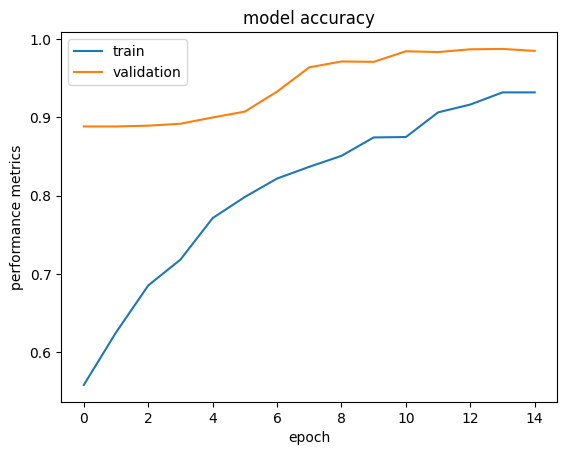

Epoch 1/15
62/69 [=========================>....] - ETA: 0s - loss: 0.8002 - binary_accuracy: 0.5348 - recall_m: 0.6241 - precision_m: 0.1450 - f1_m: 0.2300

69/69 [==============================] - 4s 12ms/step - loss: 0.7946 - binary_accuracy: 0.5386 - recall_m: 0.6354 - precision_m: 0.1504 - f1_m: 0.2379 - val_loss: 0.6219 - val_binary_accuracy: 0.8936 - val_recall_m: 0.3210 - val_precision_m: 0.5278 - val_f1_m: 0.3681
Epoch 2/15
63/69 [==========================>...] - ETA: 0s - loss: 0.6180 - binary_accuracy: 0.5967 - recall_m: 0.7862 - precision_m: 0.1938 - f1_m: 0.3013

69/69 [==============================] - 1s 11ms/step - loss: 0.6181 - binary_accuracy: 0.5977 - recall_m: 0.7806 - precision_m: 0.1943 - f1_m: 0.3010 - val_loss: 0.5559 - val_binary_accuracy: 0.9045 - val_recall_m: 0.2296 - val_precision_m: 0.5068 - val_f1_m: 0.2936
Epoch 3/15
66/69 [===========================>..] - ETA: 0s - loss: 0.5262 - binary_accuracy: 0.6567 - recall_m: 0.8170 - precision_m: 0.2329 - f1_m: 0.3485

69/69 [==============================] - 1s 9ms/step - loss: 0.5253 - binary_accuracy: 0.6573 - recall_m: 0.8178 - precision_m: 0.2341 - f1_m: 0.3502 - val_loss: 0.4917 - val_binary_accuracy: 0.9009 - val_recall_m: 0.1635 - val_precision_m: 0.4094 - val_f1_m: 0.2172
Epoch 4/15
64/69 [==========================>...] - ETA: 0s - loss: 0.4652 - binary_accuracy: 0.7109 - recall_m: 0.9000 - precision_m: 0.2735 - f1_m: 0.4031

69/69 [==============================] - 1s 9ms/step - loss: 0.4733 - binary_accuracy: 0.7105 - recall_m: 0.8881 - precision_m: 0.2745 - f1_m: 0.4030 - val_loss: 0.4275 - val_binary_accuracy: 0.9091 - val_recall_m: 0.2558 - val_precision_m: 0.5768 - val_f1_m: 0.3295
Epoch 5/15
63/69 [==========================>...] - ETA: 0s - loss: 0.4398 - binary_accuracy: 0.7515 - recall_m: 0.8857 - precision_m: 0.3181 - f1_m: 0.4494

69/69 [==============================] - 1s 9ms/step - loss: 0.4380 - binary_accuracy: 0.7432 - recall_m: 0.8717 - precision_m: 0.3058 - f1_m: 0.4338 - val_loss: 0.3832 - val_binary_accuracy: 0.9314 - val_recall_m: 0.4885 - val_precision_m: 0.7836 - val_f1_m: 0.5657
Epoch 6/15
66/69 [===========================>..] - ETA: 0s - loss: 0.3941 - binary_accuracy: 0.7760 - recall_m: 0.8498 - precision_m: 0.3270 - f1_m: 0.4514

69/69 [==============================] - 1s 11ms/step - loss: 0.3986 - binary_accuracy: 0.7764 - recall_m: 0.8419 - precision_m: 0.3306 - f1_m: 0.4524 - val_loss: 0.3201 - val_binary_accuracy: 0.9445 - val_recall_m: 0.6079 - val_precision_m: 0.8101 - val_f1_m: 0.6687
Epoch 7/15
62/69 [=========================>....] - ETA: 0s - loss: 0.3842 - binary_accuracy: 0.7989 - recall_m: 0.9097 - precision_m: 0.3614 - f1_m: 0.4778

69/69 [==============================] - 1s 11ms/step - loss: 0.3863 - binary_accuracy: 0.7991 - recall_m: 0.9054 - precision_m: 0.3634 - f1_m: 0.4797 - val_loss: 0.2774 - val_binary_accuracy: 0.9527 - val_recall_m: 0.7200 - val_precision_m: 0.7869 - val_f1_m: 0.7289
Epoch 8/15
63/69 [==========================>...] - ETA: 0s - loss: 0.3509 - binary_accuracy: 0.8180 - recall_m: 0.8893 - precision_m: 0.3865 - f1_m: 0.5107

69/69 [==============================] - 1s 9ms/step - loss: 0.3550 - binary_accuracy: 0.8200 - recall_m: 0.8852 - precision_m: 0.3893 - f1_m: 0.5146 - val_loss: 0.2526 - val_binary_accuracy: 0.9582 - val_recall_m: 0.8490 - val_precision_m: 0.7619 - val_f1_m: 0.7818
Epoch 9/15
61/69 [=========================>....] - ETA: 0s - loss: 0.3166 - binary_accuracy: 0.8448 - recall_m: 0.9028 - precision_m: 0.4355 - f1_m: 0.5617

69/69 [==============================] - 1s 9ms/step - loss: 0.3162 - binary_accuracy: 0.8418 - recall_m: 0.9056 - precision_m: 0.4275 - f1_m: 0.5563 - val_loss: 0.2306 - val_binary_accuracy: 0.9614 - val_recall_m: 0.9331 - val_precision_m: 0.7586 - val_f1_m: 0.8201
Epoch 10/15
63/69 [==========================>...] - ETA: 0s - loss: 0.3020 - binary_accuracy: 0.8566 - recall_m: 0.8625 - precision_m: 0.4504 - f1_m: 0.5709

69/69 [==============================] - 1s 9ms/step - loss: 0.3005 - binary_accuracy: 0.8573 - recall_m: 0.8679 - precision_m: 0.4514 - f1_m: 0.5736 - val_loss: 0.1738 - val_binary_accuracy: 0.9709 - val_recall_m: 0.9388 - val_precision_m: 0.8026 - val_f1_m: 0.8519
Epoch 11/15
61/69 [=========================>....] - ETA: 0s - loss: 0.2842 - binary_accuracy: 0.8750 - recall_m: 0.8977 - precision_m: 0.4898 - f1_m: 0.5946

69/69 [==============================] - 1s 11ms/step - loss: 0.2776 - binary_accuracy: 0.8791 - recall_m: 0.9059 - precision_m: 0.5037 - f1_m: 0.6108 - val_loss: 0.1615 - val_binary_accuracy: 0.9718 - val_recall_m: 0.9500 - val_precision_m: 0.8080 - val_f1_m: 0.8606
Epoch 12/15
61/69 [=========================>....] - ETA: 0s - loss: 0.2519 - binary_accuracy: 0.8924 - recall_m: 0.9509 - precision_m: 0.5280 - f1_m: 0.6508

69/69 [==============================] - 1s 9ms/step - loss: 0.2539 - binary_accuracy: 0.8909 - recall_m: 0.9400 - precision_m: 0.5235 - f1_m: 0.6451 - val_loss: 0.1715 - val_binary_accuracy: 0.9582 - val_recall_m: 0.9520 - val_precision_m: 0.7344 - val_f1_m: 0.8082
Epoch 13/15
64/69 [==========================>...] - ETA: 0s - loss: 0.2381 - binary_accuracy: 0.9028 - recall_m: 0.9384 - precision_m: 0.5650 - f1_m: 0.6677

69/69 [==============================] - 1s 12ms/step - loss: 0.2358 - binary_accuracy: 0.9018 - recall_m: 0.9429 - precision_m: 0.5565 - f1_m: 0.6604 - val_loss: 0.1216 - val_binary_accuracy: 0.9809 - val_recall_m: 0.9614 - val_precision_m: 0.8475 - val_f1_m: 0.8898
Epoch 14/15
68/69 [============================>.] - ETA: 0s - loss: 0.2368 - binary_accuracy: 0.9017 - recall_m: 0.9443 - precision_m: 0.5504 - f1_m: 0.6622

69/69 [==============================] - 1s 13ms/step - loss: 0.2356 - binary_accuracy: 0.9023 - recall_m: 0.9451 - precision_m: 0.5532 - f1_m: 0.6650 - val_loss: 0.1210 - val_binary_accuracy: 0.9795 - val_recall_m: 0.9605 - val_precision_m: 0.8480 - val_f1_m: 0.8905
Epoch 15/15
68/69 [============================>.] - ETA: 0s - loss: 0.2143 - binary_accuracy: 0.9136 - recall_m: 0.9162 - precision_m: 0.6020 - f1_m: 0.6895

518/518 [==============================] - 1s 2ms/step
Current date: 2022-03-04 00:00:00 (10/12)


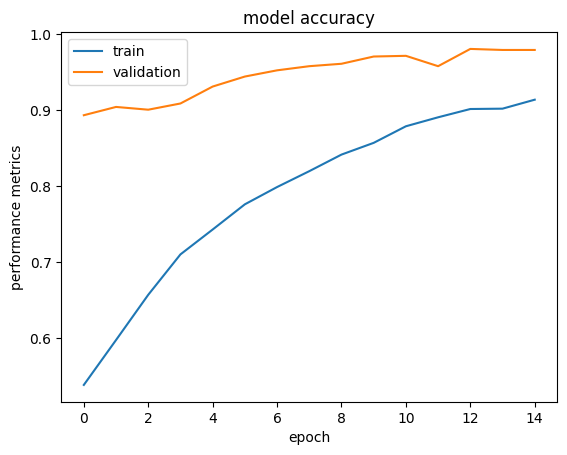

Epoch 1/15
66/75 [=========================>....] - ETA: 0s - loss: 0.7850 - binary_accuracy: 0.5483 - recall_m: 0.6175 - precision_m: 0.1605 - f1_m: 0.2423

75/75 [==============================] - 4s 13ms/step - loss: 0.7798 - binary_accuracy: 0.5517 - recall_m: 0.6323 - precision_m: 0.1611 - f1_m: 0.2450 - val_loss: 0.6651 - val_binary_accuracy: 0.7629 - val_recall_m: 0.7499 - val_precision_m: 0.3001 - val_f1_m: 0.4099
Epoch 2/15
66/75 [=========================>....] - ETA: 0s - loss: 0.5591 - binary_accuracy: 0.6402 - recall_m: 0.8192 - precision_m: 0.2234 - f1_m: 0.3393

75/75 [==============================] - 1s 9ms/step - loss: 0.5770 - binary_accuracy: 0.6408 - recall_m: 0.8109 - precision_m: 0.2281 - f1_m: 0.3426 - val_loss: 0.5814 - val_binary_accuracy: 0.8996 - val_recall_m: 0.4335 - val_precision_m: 0.5913 - val_f1_m: 0.4621
Epoch 3/15
65/75 [=========================>....] - ETA: 0s - loss: 0.5450 - binary_accuracy: 0.6827 - recall_m: 0.8546 - precision_m: 0.2672 - f1_m: 0.3907

75/75 [==============================] - 1s 7ms/step - loss: 0.5414 - binary_accuracy: 0.6804 - recall_m: 0.8578 - precision_m: 0.2585 - f1_m: 0.3793 - val_loss: 0.5161 - val_binary_accuracy: 0.9133 - val_recall_m: 0.4087 - val_precision_m: 0.6736 - val_f1_m: 0.4800
Epoch 4/15
75/75 [==============================] - ETA: 0s - loss: 0.4723 - binary_accuracy: 0.7175 - recall_m: 0.8936 - precision_m: 0.2922 - f1_m: 0.4210

75/75 [==============================] - 1s 9ms/step - loss: 0.4723 - binary_accuracy: 0.7175 - recall_m: 0.8936 - precision_m: 0.2922 - f1_m: 0.4210 - val_loss: 0.4549 - val_binary_accuracy: 0.9146 - val_recall_m: 0.4555 - val_precision_m: 0.7173 - val_f1_m: 0.5191
Epoch 5/15
65/75 [=========================>....] - ETA: 0s - loss: 0.4327 - binary_accuracy: 0.7611 - recall_m: 0.9047 - precision_m: 0.3402 - f1_m: 0.4743

75/75 [==============================] - 1s 9ms/step - loss: 0.4307 - binary_accuracy: 0.7596 - recall_m: 0.8980 - precision_m: 0.3297 - f1_m: 0.4605 - val_loss: 0.3958 - val_binary_accuracy: 0.9283 - val_recall_m: 0.6385 - val_precision_m: 0.7534 - val_f1_m: 0.6487
Epoch 6/15
75/75 [==============================] - ETA: 0s - loss: 0.4124 - binary_accuracy: 0.7925 - recall_m: 0.8906 - precision_m: 0.3639 - f1_m: 0.4974

75/75 [==============================] - 1s 9ms/step - loss: 0.4124 - binary_accuracy: 0.7925 - recall_m: 0.8906 - precision_m: 0.3639 - f1_m: 0.4974 - val_loss: 0.3460 - val_binary_accuracy: 0.9337 - val_recall_m: 0.8019 - val_precision_m: 0.7060 - val_f1_m: 0.7186
Epoch 7/15
69/75 [==========================>...] - ETA: 0s - loss: 0.4014 - binary_accuracy: 0.8098 - recall_m: 0.8646 - precision_m: 0.3959 - f1_m: 0.5190

75/75 [==============================] - 1s 10ms/step - loss: 0.4016 - binary_accuracy: 0.8092 - recall_m: 0.8687 - precision_m: 0.3941 - f1_m: 0.5183 - val_loss: 0.3003 - val_binary_accuracy: 0.9438 - val_recall_m: 0.8643 - val_precision_m: 0.7136 - val_f1_m: 0.7531
Epoch 8/15
75/75 [==============================] - ETA: 0s - loss: 0.3504 - binary_accuracy: 0.8375 - recall_m: 0.9241 - precision_m: 0.4287 - f1_m: 0.5565

75/75 [==============================] - 1s 7ms/step - loss: 0.3504 - binary_accuracy: 0.8375 - recall_m: 0.9241 - precision_m: 0.4287 - f1_m: 0.5565 - val_loss: 0.2475 - val_binary_accuracy: 0.9508 - val_recall_m: 0.8945 - val_precision_m: 0.7397 - val_f1_m: 0.7838
Epoch 9/15
75/75 [==============================] - ETA: 0s - loss: 0.3480 - binary_accuracy: 0.8462 - recall_m: 0.8861 - precision_m: 0.4417 - f1_m: 0.5632

75/75 [==============================] - 1s 7ms/step - loss: 0.3480 - binary_accuracy: 0.8462 - recall_m: 0.8861 - precision_m: 0.4417 - f1_m: 0.5632 - val_loss: 0.2456 - val_binary_accuracy: 0.9379 - val_recall_m: 0.9631 - val_precision_m: 0.6547 - val_f1_m: 0.7579
Epoch 10/15
71/75 [===========================>..] - ETA: 0s - loss: 0.3329 - binary_accuracy: 0.8574 - recall_m: 0.8995 - precision_m: 0.4696 - f1_m: 0.5701

75/75 [==============================] - 1s 11ms/step - loss: 0.3383 - binary_accuracy: 0.8562 - recall_m: 0.8948 - precision_m: 0.4718 - f1_m: 0.5716 - val_loss: 0.2288 - val_binary_accuracy: 0.9450 - val_recall_m: 0.9781 - val_precision_m: 0.6807 - val_f1_m: 0.7800
Epoch 11/15
70/75 [===========================>..] - ETA: 0s - loss: 0.3095 - binary_accuracy: 0.8665 - recall_m: 0.8730 - precision_m: 0.4716 - f1_m: 0.5814

75/75 [==============================] - 1s 10ms/step - loss: 0.3190 - binary_accuracy: 0.8629 - recall_m: 0.8708 - precision_m: 0.4697 - f1_m: 0.5757 - val_loss: 0.1988 - val_binary_accuracy: 0.9533 - val_recall_m: 0.9840 - val_precision_m: 0.7147 - val_f1_m: 0.8094
Epoch 12/15
74/75 [============================>.] - ETA: 0s - loss: 0.2770 - binary_accuracy: 0.8872 - recall_m: 0.9079 - precision_m: 0.5265 - f1_m: 0.6379

75/75 [==============================] - 1s 10ms/step - loss: 0.2763 - binary_accuracy: 0.8875 - recall_m: 0.9091 - precision_m: 0.5283 - f1_m: 0.6400 - val_loss: 0.2079 - val_binary_accuracy: 0.9488 - val_recall_m: 0.9822 - val_precision_m: 0.6941 - val_f1_m: 0.7951
Epoch 13/15
74/75 [============================>.] - ETA: 0s - loss: 0.2746 - binary_accuracy: 0.8872 - recall_m: 0.9444 - precision_m: 0.5339 - f1_m: 0.6474

75/75 [==============================] - 1s 12ms/step - loss: 0.2755 - binary_accuracy: 0.8863 - recall_m: 0.9318 - precision_m: 0.5268 - f1_m: 0.6388 - val_loss: 0.1311 - val_binary_accuracy: 0.9775 - val_recall_m: 0.9867 - val_precision_m: 0.8334 - val_f1_m: 0.8921
Epoch 14/15
68/75 [==========================>...] - ETA: 0s - loss: 0.2237 - binary_accuracy: 0.9053 - recall_m: 0.9200 - precision_m: 0.5830 - f1_m: 0.6789

75/75 [==============================] - 1s 12ms/step - loss: 0.2289 - binary_accuracy: 0.9038 - recall_m: 0.9237 - precision_m: 0.5804 - f1_m: 0.6790 - val_loss: 0.1454 - val_binary_accuracy: 0.9688 - val_recall_m: 0.9867 - val_precision_m: 0.7833 - val_f1_m: 0.8601
Epoch 15/15
65/75 [=========================>....] - ETA: 0s - loss: 0.2101 - binary_accuracy: 0.9159 - recall_m: 0.9579 - precision_m: 0.5969 - f1_m: 0.7059

499/499 [==============================] - 1s 2ms/step
Current date: 2022-03-05 00:00:00 (11/12)


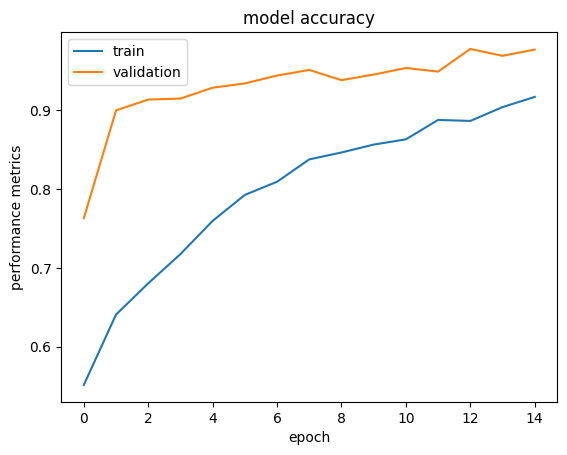

Epoch 1/15
78/82 [===========================>..] - ETA: 0s - loss: 0.7285 - binary_accuracy: 0.5629 - recall_m: 0.6867 - precision_m: 0.1590 - f1_m: 0.2436

82/82 [==============================] - 3s 14ms/step - loss: 0.7259 - binary_accuracy: 0.5658 - recall_m: 0.6888 - precision_m: 0.1638 - f1_m: 0.2491 - val_loss: 0.6322 - val_binary_accuracy: 0.8927 - val_recall_m: 0.4539 - val_precision_m: 0.5318 - val_f1_m: 0.4541
Epoch 2/15
80/82 [============================>.] - ETA: 0s - loss: 0.5581 - binary_accuracy: 0.6391 - recall_m: 0.8436 - precision_m: 0.2199 - f1_m: 0.3349

82/82 [==============================] - 1s 9ms/step - loss: 0.5573 - binary_accuracy: 0.6396 - recall_m: 0.8444 - precision_m: 0.2203 - f1_m: 0.3357 - val_loss: 0.5497 - val_binary_accuracy: 0.9112 - val_recall_m: 0.3174 - val_precision_m: 0.5894 - val_f1_m: 0.3801
Epoch 3/15
81/82 [============================>.] - ETA: 0s - loss: 0.5008 - binary_accuracy: 0.6960 - recall_m: 0.8156 - precision_m: 0.2555 - f1_m: 0.3683

82/82 [==============================] - 1s 10ms/step - loss: 0.5045 - binary_accuracy: 0.6962 - recall_m: 0.8138 - precision_m: 0.2605 - f1_m: 0.3720 - val_loss: 0.4855 - val_binary_accuracy: 0.9150 - val_recall_m: 0.3744 - val_precision_m: 0.6264 - val_f1_m: 0.4375
Epoch 4/15
75/82 [==========================>...] - ETA: 0s - loss: 0.4561 - binary_accuracy: 0.7358 - recall_m: 0.8529 - precision_m: 0.2920 - f1_m: 0.4144

82/82 [==============================] - 1s 9ms/step - loss: 0.4547 - binary_accuracy: 0.7335 - recall_m: 0.8468 - precision_m: 0.2862 - f1_m: 0.4083 - val_loss: 0.4261 - val_binary_accuracy: 0.9273 - val_recall_m: 0.5314 - val_precision_m: 0.7040 - val_f1_m: 0.5740
Epoch 5/15
78/82 [===========================>..] - ETA: 0s - loss: 0.4347 - binary_accuracy: 0.7680 - recall_m: 0.8561 - precision_m: 0.3272 - f1_m: 0.4514

82/82 [==============================] - 1s 10ms/step - loss: 0.4286 - binary_accuracy: 0.7688 - recall_m: 0.8631 - precision_m: 0.3259 - f1_m: 0.4515 - val_loss: 0.3754 - val_binary_accuracy: 0.9365 - val_recall_m: 0.7389 - val_precision_m: 0.6895 - val_f1_m: 0.6861
Epoch 6/15
80/82 [============================>.] - ETA: 0s - loss: 0.4158 - binary_accuracy: 0.7984 - recall_m: 0.8334 - precision_m: 0.3571 - f1_m: 0.4820

82/82 [==============================] - 1s 10ms/step - loss: 0.4133 - binary_accuracy: 0.7988 - recall_m: 0.8374 - precision_m: 0.3642 - f1_m: 0.4881 - val_loss: 0.3171 - val_binary_accuracy: 0.9454 - val_recall_m: 0.7771 - val_precision_m: 0.7262 - val_f1_m: 0.7283
Epoch 7/15
80/82 [============================>.] - ETA: 0s - loss: 0.3483 - binary_accuracy: 0.8238 - recall_m: 0.9010 - precision_m: 0.4029 - f1_m: 0.5280

82/82 [==============================] - 1s 11ms/step - loss: 0.3476 - binary_accuracy: 0.8238 - recall_m: 0.8912 - precision_m: 0.3991 - f1_m: 0.5233 - val_loss: 0.2745 - val_binary_accuracy: 0.9427 - val_recall_m: 0.8500 - val_precision_m: 0.6720 - val_f1_m: 0.7299
Epoch 8/15
77/82 [===========================>..] - ETA: 0s - loss: 0.3396 - binary_accuracy: 0.8381 - recall_m: 0.9146 - precision_m: 0.4203 - f1_m: 0.5412

82/82 [==============================] - 1s 13ms/step - loss: 0.3429 - binary_accuracy: 0.8377 - recall_m: 0.9015 - precision_m: 0.4130 - f1_m: 0.5322 - val_loss: 0.2626 - val_binary_accuracy: 0.9358 - val_recall_m: 0.9053 - val_precision_m: 0.6342 - val_f1_m: 0.7250
Epoch 9/15
81/82 [============================>.] - ETA: 0s - loss: 0.2972 - binary_accuracy: 0.8673 - recall_m: 0.9513 - precision_m: 0.4647 - f1_m: 0.5996

82/82 [==============================] - 1s 13ms/step - loss: 0.2974 - binary_accuracy: 0.8669 - recall_m: 0.9397 - precision_m: 0.4590 - f1_m: 0.5923 - val_loss: 0.2091 - val_binary_accuracy: 0.9523 - val_recall_m: 0.9205 - val_precision_m: 0.6926 - val_f1_m: 0.7745
Epoch 10/15
78/82 [===========================>..] - ETA: 0s - loss: 0.2918 - binary_accuracy: 0.8818 - recall_m: 0.8940 - precision_m: 0.4931 - f1_m: 0.6021

82/82 [==============================] - 1s 13ms/step - loss: 0.2959 - binary_accuracy: 0.8819 - recall_m: 0.8968 - precision_m: 0.4974 - f1_m: 0.6063 - val_loss: 0.1947 - val_binary_accuracy: 0.9558 - val_recall_m: 0.9233 - val_precision_m: 0.7079 - val_f1_m: 0.7841
Epoch 11/15
77/82 [===========================>..] - ETA: 0s - loss: 0.2639 - binary_accuracy: 0.8888 - recall_m: 0.8728 - precision_m: 0.5090 - f1_m: 0.6191

82/82 [==============================] - 1s 12ms/step - loss: 0.2617 - binary_accuracy: 0.8888 - recall_m: 0.8744 - precision_m: 0.5059 - f1_m: 0.6160 - val_loss: 0.1770 - val_binary_accuracy: 0.9592 - val_recall_m: 0.9299 - val_precision_m: 0.7143 - val_f1_m: 0.7946
Epoch 12/15
80/82 [============================>.] - ETA: 0s - loss: 0.2529 - binary_accuracy: 0.8953 - recall_m: 0.9149 - precision_m: 0.5421 - f1_m: 0.6423

82/82 [==============================] - 1s 10ms/step - loss: 0.2542 - binary_accuracy: 0.8965 - recall_m: 0.9109 - precision_m: 0.5533 - f1_m: 0.6469 - val_loss: 0.1439 - val_binary_accuracy: 0.9708 - val_recall_m: 0.9345 - val_precision_m: 0.7608 - val_f1_m: 0.8255
Epoch 13/15
77/82 [===========================>..] - ETA: 0s - loss: 0.2401 - binary_accuracy: 0.8929 - recall_m: 0.8934 - precision_m: 0.5381 - f1_m: 0.6438

82/82 [==============================] - 1s 9ms/step - loss: 0.2405 - binary_accuracy: 0.8942 - recall_m: 0.8999 - precision_m: 0.5400 - f1_m: 0.6470 - val_loss: 0.1846 - val_binary_accuracy: 0.9527 - val_recall_m: 0.9289 - val_precision_m: 0.6963 - val_f1_m: 0.7791
Epoch 14/15
77/82 [===========================>..] - ETA: 0s - loss: 0.2108 - binary_accuracy: 0.9103 - recall_m: 0.9535 - precision_m: 0.5774 - f1_m: 0.6861

82/82 [==============================] - 1s 9ms/step - loss: 0.2116 - binary_accuracy: 0.9096 - recall_m: 0.9441 - precision_m: 0.5661 - f1_m: 0.6755 - val_loss: 0.1064 - val_binary_accuracy: 0.9815 - val_recall_m: 0.9319 - val_precision_m: 0.8233 - val_f1_m: 0.8637
Epoch 15/15
79/82 [===========================>..] - ETA: 0s - loss: 0.1980 - binary_accuracy: 0.9241 - recall_m: 0.9529 - precision_m: 0.6224 - f1_m: 0.7112

500/500 [==============================] - 1s 2ms/step
Current date: 2022-03-06 00:00:00 (12/12)


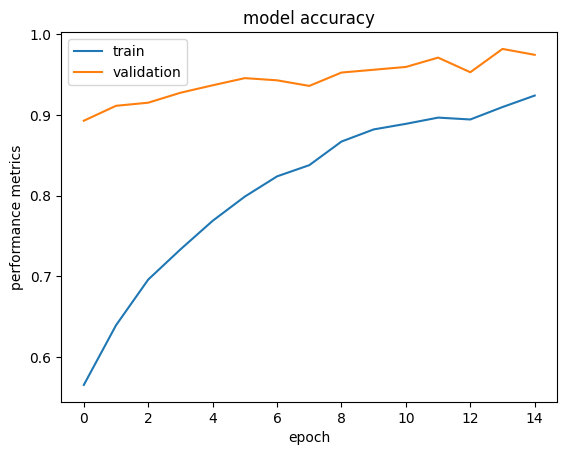

In [ ]:

# Dict with all the labelled elements, every iteration it is filled with #{BUDGET} more labelled elements
labelled_elements = {}

x, y = [], []

metrics_functions = {"precision":precision_score,
                     "f1":f1_score,
                     "recall":recall_score}


metrics = {"train_accuracy":[],
           "precision":[],
           "recall":[],
           "f1":[],
           "time_elapsed":[]}

delta = pd.Timedelta(hours=TIMEFRAME)
dates = pd.date_range(min_date, max_date - delta, freq=delta)

for index, date in enumerate(dates):
  start_time = time.time()

  curr = df[(df['ts'] >= date) & (df['ts'] < date + delta)]
  next = df[(df['ts'] >= date + delta) & (df['ts'] < date + 2*delta)]
  # ACTIVE LEARNING PART: selecting which elements to use for training
  if AL_EFFICIENCY == "optimal":
    x.extend(curr["embedding"])
    y.extend(classify(i) for i in curr[LABEL])
  elif AL_EFFICIENCY == "normal":
    labelled_elements = al_methods[AL_METHOD](curr, labelled_elements, BUDGET, LABEL)
    x, y = list(labelled_elements.keys()), list(labelled_elements.values())
  elif AL_EFFICIENCY == "forgetful":
    labelled_elements = al_methods[AL_METHOD](curr, {}, BUDGET, LABEL)
    x, y = list(labelled_elements.keys()), list(labelled_elements.values())
  else:
      x, y = [], []

  # Getting correct sets
  x_train, y_train, x_test, y_test, x_val, y_val = get_network_sets(x, y, next)

  # Creating model
  model, callback = create_model()

  # Calculating weights for better cnn performance
  class_weights = compute_class_weight(class_weight='balanced', classes=list(set(y)), y=y)
  class_weights = {class_index: weight for class_index, weight in enumerate(class_weights)}

  # Training model
  history = model.fit(x_train, y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=1,
                      validation_data=([x_val, y_val]),
                      callbacks=callback,
                      class_weight=class_weights)

  delta_time = time.time() - start_time

  # Saving metrics
  for i in metrics.keys():
    if i in metrics_functions.keys():
      metrics[i].append(metrics_functions[i](y_test, [decision(i_test) for i_test in model.predict(x_test)]))
    elif i == "train_accuracy":
      metrics[i].append(history.history["binary_accuracy"][-1])
    elif i == "time_elapsed":
      metrics[i].append(delta_time)

  print(f"Current date: {date} ({index}/{len(dates)-1})")
  plot_results(history)



### Examples

In [ ]:

examples = {"Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll" : 1.0,
            "Immaculate bundles of joy, frolicking furballs with hearts full of love – that's the adorable charm of cute puppies" : 0.0,
            "Another day, another loss. Dionisi has to leave if Sassuolo wants to stay in Serie A #DionisiOUT #Empoli-Sassuolo #6-1" : 0.0,
            "Inter Milano has defeated Dynamo Kiev once again! What a slaughter! ⚽️🔵⚫️" : 0.0,
            "Thoughts with Palestine during this difficult time, may the souls of the departed find tranquility in the afterlife 🕊️💔 #EternalPeace" : 1.0,
}

for text_example, label in examples.items():

  encoded_text = [embed_text(text_example)]
  encoded_text = np.array(encoded_text)

  output = model.predict(encoded_text)[0][0]

  print(f"Text: {text_example}\nDesired output: {decision(label)}\nActual output: {decision(output)} ({output})")


1/1 [==============================] - 0s 27ms/step
Text: Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll
Desired output: True
Actual output: True (0.9077619314193726)
1/1 [==============================] - 0s 21ms/step
Text: Immaculate bundles of joy, frolicking furballs with hearts full of love – that's the adorable charm of cute puppies
Desired output: False
Actual output: False (0.016599155962467194)
1/1 [==============================] - 0s 18ms/step
Text: Another day, another loss. Dionisi has to leave if Sassuolo wants to stay in Serie A #DionisiOUT #Empoli-Sassuolo #6-1
Desired output: False
Actual output: True (0.9814693927764893)
1/1 [==============================] - 0s 20ms/step
Text: Inter Milano has defeated Dynamo Kiev once again! What a slaughter! ⚽️🔵⚫️
Desired output: False
Actual output: False (0.29566097259521484)
1/1 [==============================] - 0s 17ms/step
Text: Thoughts with Palestine during this diffic

In [ ]:
# @title Try it out!

TWEET = "Putin just \"gifted\" a new \"toy\" to Palestinian people to use with Israel" # @param {type:"string"}
EXPECTED_RESULT = True # @param {type:"boolean"}
encoded_text = [embed_text(TWEET)]
encoded_text = np.array(encoded_text)

output = model.predict(encoded_text)[0][0]

print(f"Text: {TWEET}\nDesired output: {decision(EXPECTED_RESULT)}\nActual output: {decision(output)} ({output})")


1/1 [==============================] - 0s 18ms/step
Text: Putin just "gifted" a new "toy" to Palestinian people to use with Israel
Desired output: True
Actual output: True (0.5887908339500427)


In [ ]:
save_model(model, title=NAME, metrics=metrics)
print(f"{NAME} model saved!")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


prova model saved!
